In [1]:
# some standard python imports #

import numpy as np
import pandas as pd
import math
from astropy.stats import sigma_clipped_stats
from scipy.spatial import KDTree

import matplotlib
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt

import illustris_python as il
import MAS_library as MASL
import smoothing_library as SL

In [2]:
def inttopair(n, num_columns):
    row = n // num_columns
    col = n % num_columns
    return row, col

In [139]:
def deltamaker(pos):
    
    
    grid = 116                         #this is how you specify the size of your density grid (I just made it 100x100)
    MAS      = 'CIC'                   #Cloud-in-Cell. This is just the interpolation scheme we are using to calculate the density
    BoxSize = 75                       #from simulation params. Mpc/h 
    R = 4                              #smoothing kernal in Mpc/h
    Filter  = 'Top-Hat'                #type of smoothing kernal 
    threads = 8                        #computer threads, for parallelization 

    
    #Get density field.  MASL.MA is filling in the values of delta_g using CIC interpolation
    delta = np.zeros((grid,grid,grid), dtype=np.float32)
    MASL.MA(pos, delta, BoxSize, MAS, verbose=False)
    delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0

    # smooth the field
    W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)
    delta_smoothed = SL.field_smoothing(delta, W_k, threads)

    return delta_smoothed


In [18]:
def snapmaker(basePath,num):
    snap=il.snapshot.loadSubset(basePath,num,'dm')
    snap_pos=np.array(snap['Coordinates'],dtype=np.float32)/1000
    snap_delta=deltamaker(snap_pos)
    return snap_delta

In [123]:
def groupmaker(basePath,num,k_max,k_min):
    group=il.groupcat.loadSubhalos(basePath,num)
    group_pos=np.array(group['SubhaloPos'])/1000
    group_mag=np.array(group['SubhaloStellarPhotometrics'][:,3])
    sorting=[group_mag,group_pos]
    sort=sorter(k_max,k_min,sorting)
    group_pos=sort[1]
    group_mag=sort[0]
    delta_g=deltamaker(group_pos)
    return delta_g, group_mag, group_pos

In [30]:
def sorter(high,low,arr):
    basear=arr[0]
    idx=np.where((basear>low) & (basear<high))[0]
    sortar=[]
    for i in arr:
        tempar=i[idx]
        sortar.append(tempar)
    return sortar

In [48]:
def binmaker(maxi,mini,size,delta,delta_g,pos,bin_ar):
    step=np.abs(maxi-mini)/size
    low=mini
    high=low+step

    sorting=[bin_ar,pos]
    b_list=[]
    bin_list=[]
    label_list=[]
    for i in range(size):
        tempsorted=sorter(high,low,sorting)
        tempbin=tempsorted[0]
        
        temppos=np.array(np.rint(tempsorted[1]),dtype=int)
        tempdelta_g=np.array([delta_g[x,y,z] for x, y, z in temppos])
        tempdelta=np.array([delta[x,y,z] for x, y, z in temppos])
        tempb=tempdelta_g/tempdelta       
        
        templabel=str(low)+" - "+str(high)

        b_list.append(tempb)
        bin_list.append(tempbin)
        label_list.append(templabel)

        low=high
        high=low+step

    return b_list, bin_list, label_list

In [76]:
def biashist(b_list,label_list,single,save,sim):
    if single == True:
        plt.figure(figsize=(15,10))
        hist = plt.hist(b_list, bins = np.linspace(-2,3,100))
        plt.xlabel('Bias')
        plt.ylabel('Number of points in the grid')
        plt.grid()
        if save==True:
            plt.savefig("Collected_Bias_"+sim+".png",format="png")
        plt.show()
    else:  
        
        size=len(b_list)
        color_list=cm.rainbow(np.linspace(0,1,size))

        plt.figure(figsize=(15,10))
        hist = plt.hist(b_list,bins = np.linspace(-2,3,100),label=label_list,stacked=True,density=False,color=color_list)
        plt.legend()
        plt.title('Linear Bias')
        plt.xlabel('Bias')
        plt.ylabel('Number of points in the grid')
        plt.grid()
        if save==True:
            plt.savefig("Binned_Bias_"+sim+".png",format="png")
        plt.show()
        
        height=math.ceil(size/3)
        fig =plt.figure(figsize=(45,30))
        for i in range(size):
            q,r=inttopair(i,3)
            ax = plt.subplot2grid((height, 3), (q, r), rowspan=1, colspan=1)
            
            hist = ax.hist(b_list[i], bins = np.linspace(-2,3,100),label=label_list[i],color=color_list[i])
            ax.legend()
            ax.title.set_text('Linear Bias')
            ax.set_xlabel('Bias')
            ax.set_ylabel('Number of points in the grid')
            ax.grid()
        plt.tight_layout()
        if save==True:
            plt.savefig("Ind_Binned_Bias_"+sim+".png",format="png")
        plt.show()

In [91]:
def mdstdmaker(b_list, bin_list):
    md_list=[]
    mder_list=[]
    std_list=[]
    mdbin_list=[]
    for i in range(len(b_list)): 
        binmed=np.median(bin_list[i])
        mn,md,std=sigma_clipped_stats(b_list[i])
        mder=std/np.sqrt(len(bin_list[i]))
        md_list.append(md)
        mder_list.append(mder)
        std_list.append(std)
        mdbin_list.append(binmed)
    return mdbin_list, md_list, mder_list, std_list

In [73]:
def envmaker(pos):
    kdtree=KDTree(pos)
    env,points=kdtree.query(pos,3)
    env_list=np.array([i[2] for i in env])

    return env_list

In [166]:
def medscat(bin_list,md_list,mder_list,xlabel,save,sim,comp):
    if comp==False:
        color_list='black'
        plt.figure(figsize=(15,10))
        plt.errorbar(bin_list,md_list,yerr=mder_list,ecolor=color_list, capsize=5, capthick=2, elinewidth=1)
        plt.scatter(bin_list,md_list,color=color_list)
        plt.title('Linear Bias Medians Vs '+xlabel)
        plt.xlabel(xlabel)
        plt.ylabel('Bias Median')
        plt.grid()
        if save==True:
            plt.savefig('Biasmed_'+xlabel+'+error_'+sim+'.png',format="png")
        plt.show()
    else:
        size=len(bin_list)
        color_list=cm.rainbow(np.linspace(0,1,size))
        plt.figure(figsize=(15,10))
        for i in range(size):
            plt.errorbar(bin_list[i],md_list[i],yerr=mder_list[i],ecolor=color_list[i], capsize=5, capthick=2, elinewidth=1)
            plt.scatter(bin_list[i],md_list[i],color=color_list[i],label=sim[i])
        plt.legend()
        plt.title('Linear Bias Medians Vs '+xlabel)
        plt.xlabel(xlabel)
        plt.ylabel('Bias Median')
        plt.grid()
        if save==True:
            simname="_".join(sim)
            plt.savefig('Biasmed_'+xlabel+'+error_'+simname+'.png',format="png")
        plt.show()


In [173]:
def stdscat(bin_list,std_list,xlabel,save,sim,comp):
    if comp==False:
        plt.figure(figsize=(15,10))
        plt.errorbar(bin_list,std_list,ecolor="black", capsize=5, capthick=2, elinewidth=1)
        plt.scatter(bin_list,std_list,color="black")
        plt.title('Linear Bias Standard Deviations Vs '+xlabel)
        plt.xlabel(xlabel)
        plt.ylabel('Bias STD')
        plt.grid()
        if save==True:
            plt.savefig('Biasstd_'+xlabel+'+error_'+sim+'.png',format="png")
        plt.show()
    else:
        size=len(bin_list)
        color_list=cm.rainbow(np.linspace(0,1,size))
        plt.figure(figsize=(15,10))
        for i in range(size):
            plt.errorbar(bin_list[i],std_list[i],ecolor=color_list[i], capsize=5, capthick=2, elinewidth=1)
            plt.scatter(bin_list[i],std_list[i],color=color_list[i],label=sim[i])
        plt.legend()
        plt.title('Linear Bias Standard Deviations Vs '+xlabel)
        plt.xlabel(xlabel)
        plt.ylabel('Bias STD')
        plt.grid()
        if save==True:
            simname="_".join(sim)
            plt.savefig('Biasstd_'+xlabel+'+error_'+simname+'.png',format="png")
        plt.show()
        

In [176]:
def OGmaker(group_path, snap_path, k_max,k_min):
    #Read in galaxy data
    filename = group_path
    galaxycat  = pd.read_csv(filename)
    
    ##Read in the snapshot data 
    
    snapshot = snap_path         #name of Gadget file
    ptypes = [1]                       #this specifies that the simulation only contains dark matter particles
    grid = 116                         #this is how you specify the size of your density grid (I just made it 100x100) (116 to collect all galaxies)
    MAS      = 'CIC'                   #Cloud-in-Cell. This is just the interpolation scheme we are using to calculate the density
    do_RSD   = False                   #don't do redshift-space distortions (https://en.wikipedia.org/wiki/Redshift-space_distortions)
    axis     = 0                       #axis along which to place RSD; not used here
    verbose  = False                   #whether to print information on the progress
    
    
    # Compute the effective number of particles/mass in each voxel
    delta = MASL.density_field_gadget(snapshot, ptypes, grid, MAS, do_RSD, axis, verbose)
    
    # compute density contrast: delta = rho/<rho> - 1
    delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0
    
    BoxSize = 115  #from simulation params. Mpc/h 
    R = 4       #smoothing kernal in Mpc/h
    grid = delta.shape[0]
    Filter  = 'Top-Hat' #type of smoothing kernal 
    threads = 8   #computer threads, for parallelization 
    
    # compute FFT (fast fourier transform) of the filter
    W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)
    
    # smooth the field
    delta_og = SL.field_smoothing(delta, W_k, threads)
    
    
    pos = galaxycat.loc[:,['x','y','z']].to_numpy(dtype=np.float32)
    mag = galaxycat.loc[:,'K_Mag'].to_numpy(dtype=np.float32)
    sorting=[mag,pos]
    sort=sorter(k_max,k_min,sorting)
    pos=sort[1]
    mag=sort[0]
    
    #Get density field.  MASL.MA is filling in the values of delta_g using CIC interpolation
    delta_g = np.zeros((grid,grid,grid), dtype=np.float32)
    MASL.MA(pos, delta_g, BoxSize, MAS, verbose=False)
    delta_g /= np.mean(delta_g, dtype=np.float64);  delta_g -= 1.0
    
    
    
    # smooth the field
    W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)
    delta_g_og = SL.field_smoothing(delta_g, W_k, threads)
    return delta_og, delta_g_og, mag, pos

In [129]:
#Set up (Alter paths as need be)
basePath1='/Volumes/Seagate/TNG100-3/output'
basePath2='/Volumes/Seagate/TNG100-1/output'
OGsnapPath='./Downloads/snapshot_500'
OGgroupPath = './Downloads/galaxycat.csv'
scale=1
k_max=-20
k_min=-27
bin_num=14
env_max=6
env_min=0
TNG='TNG'
OG='OG'


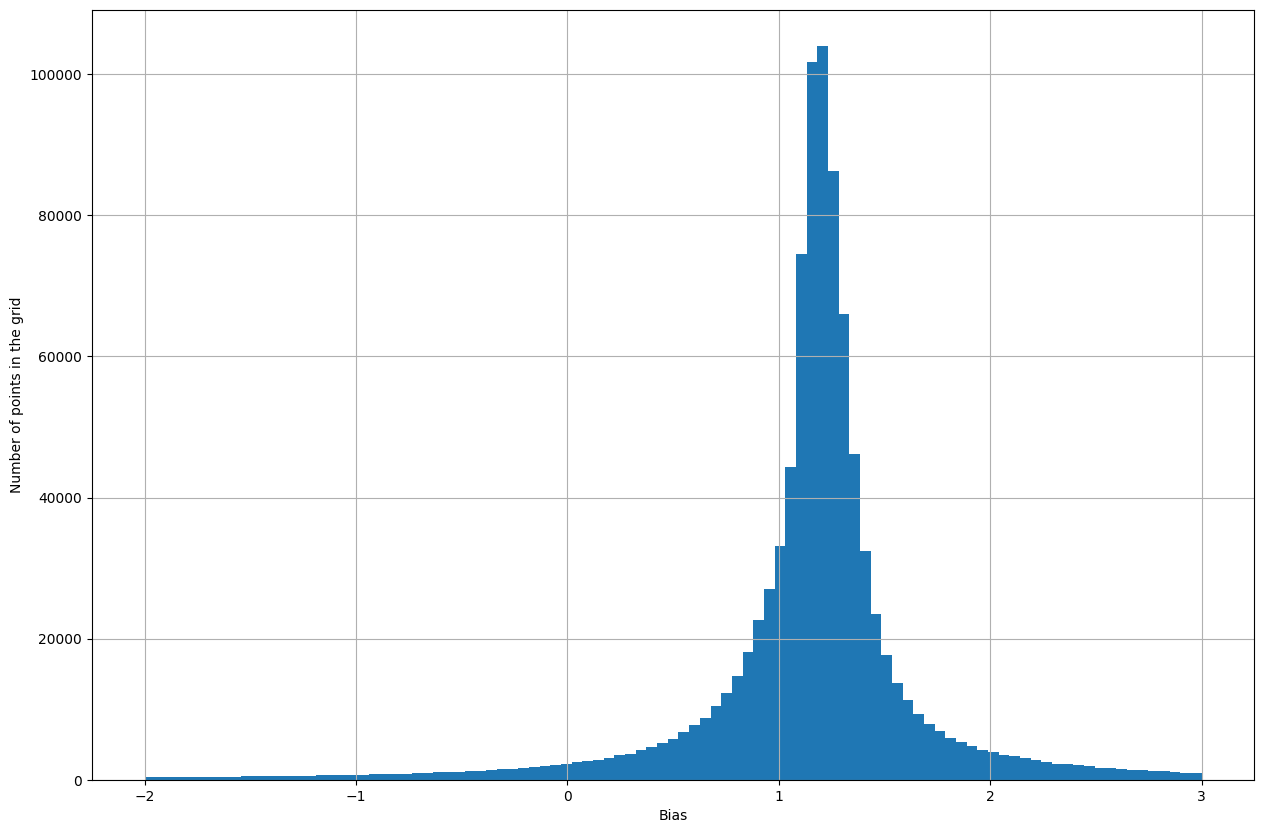

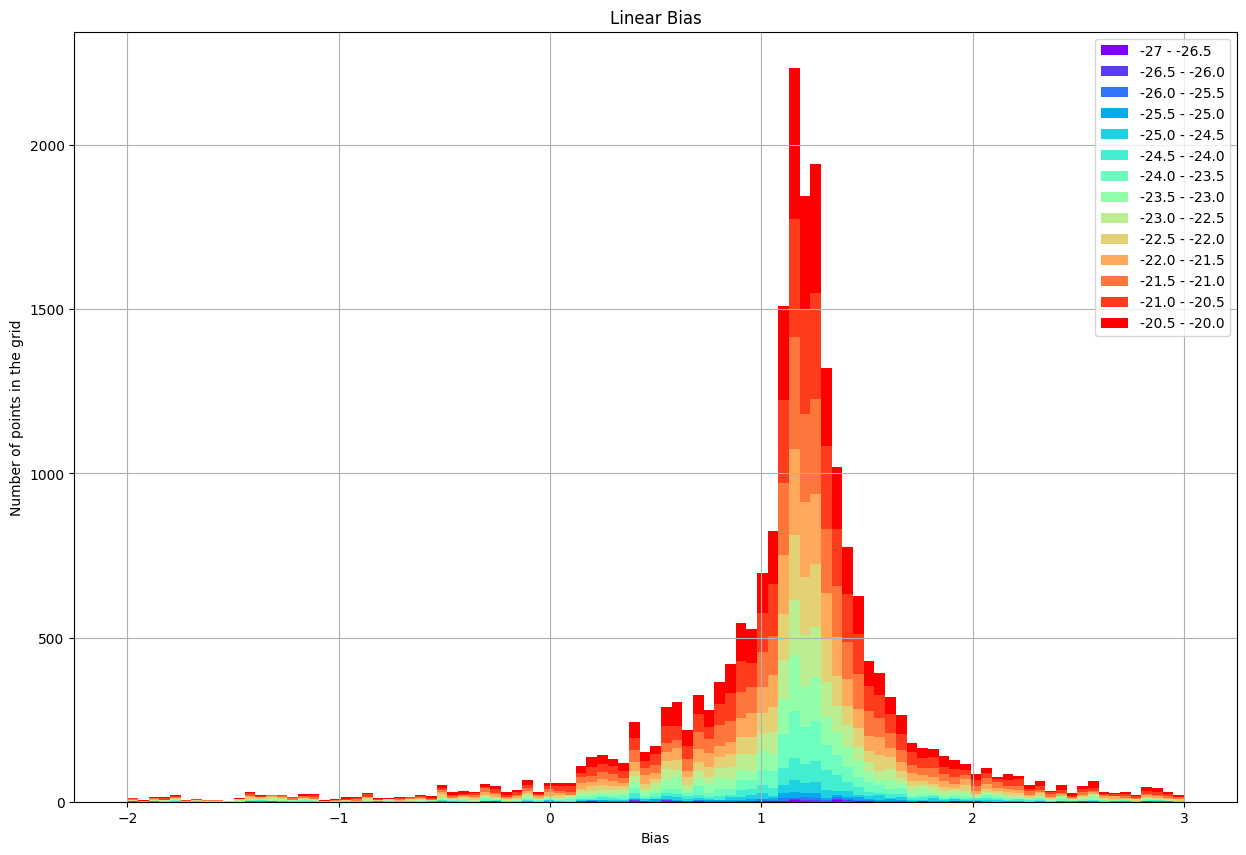

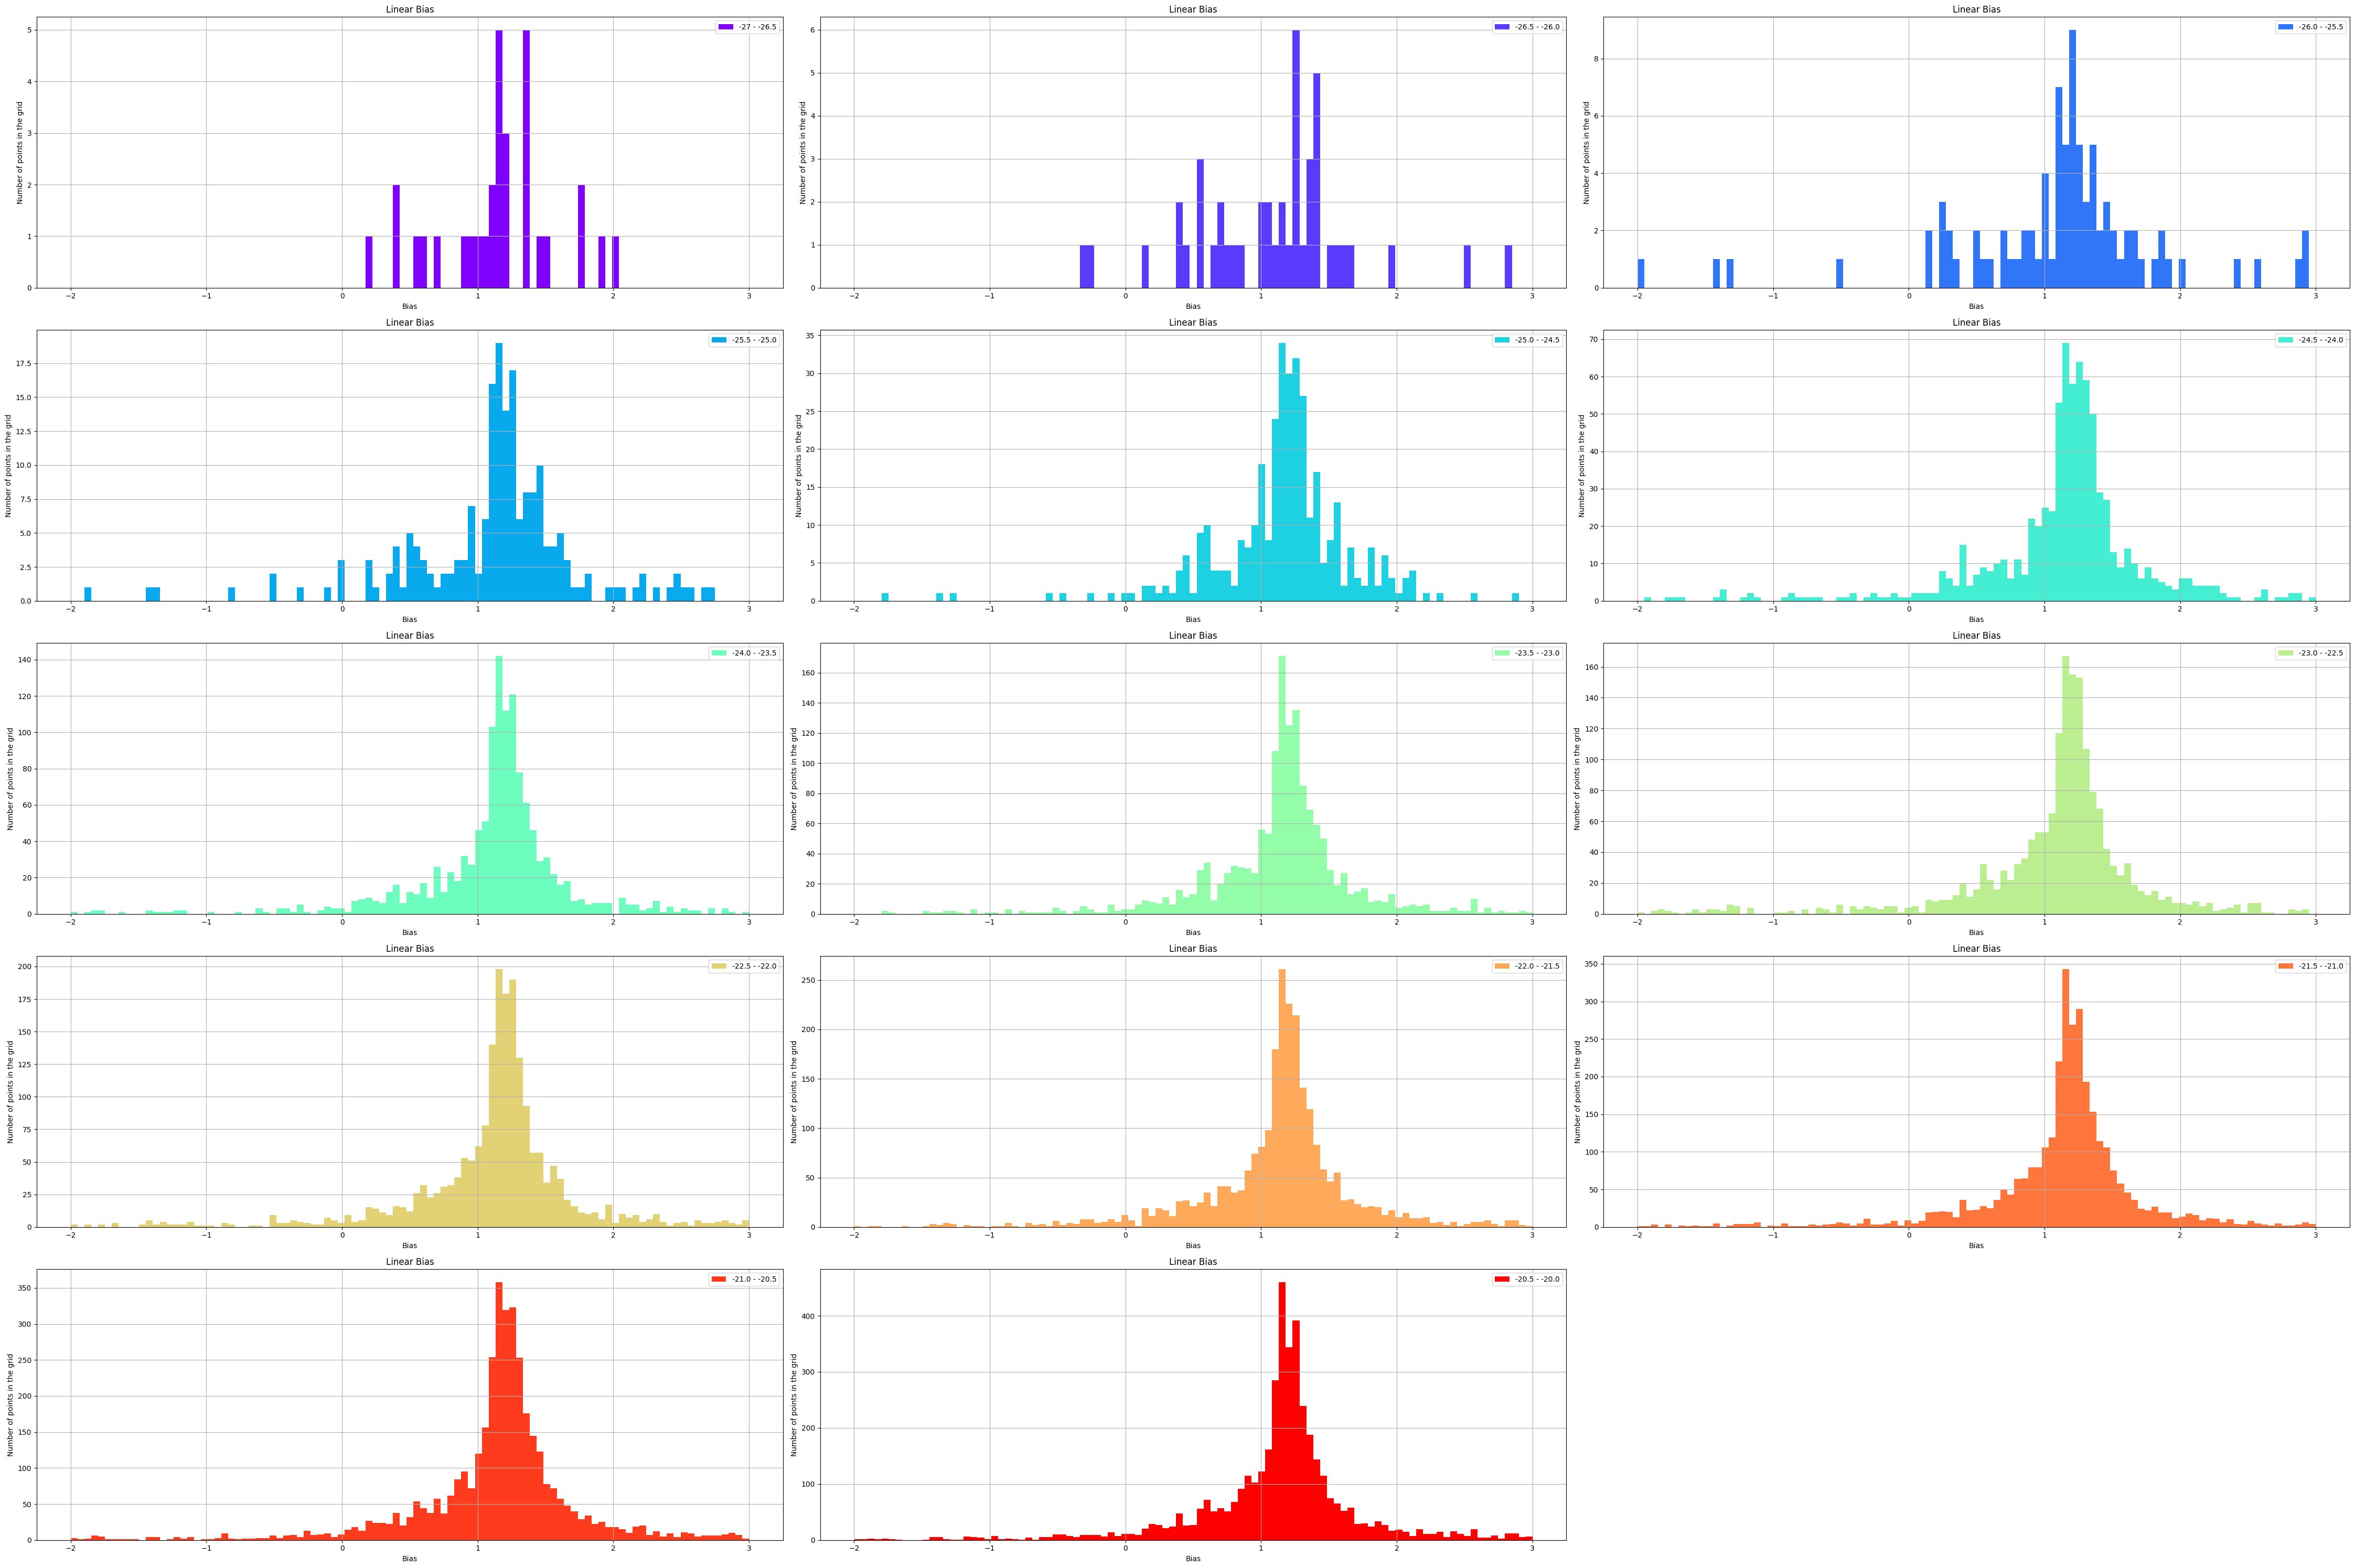

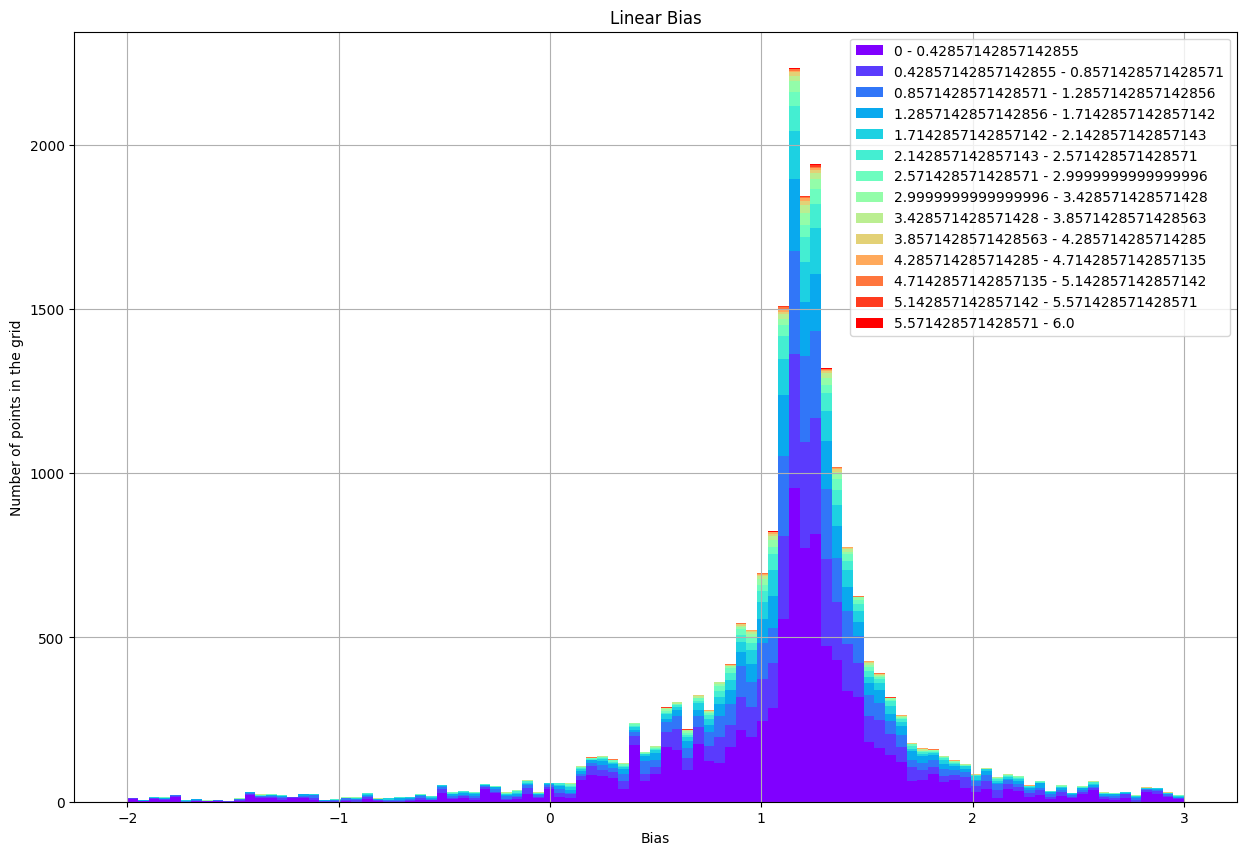

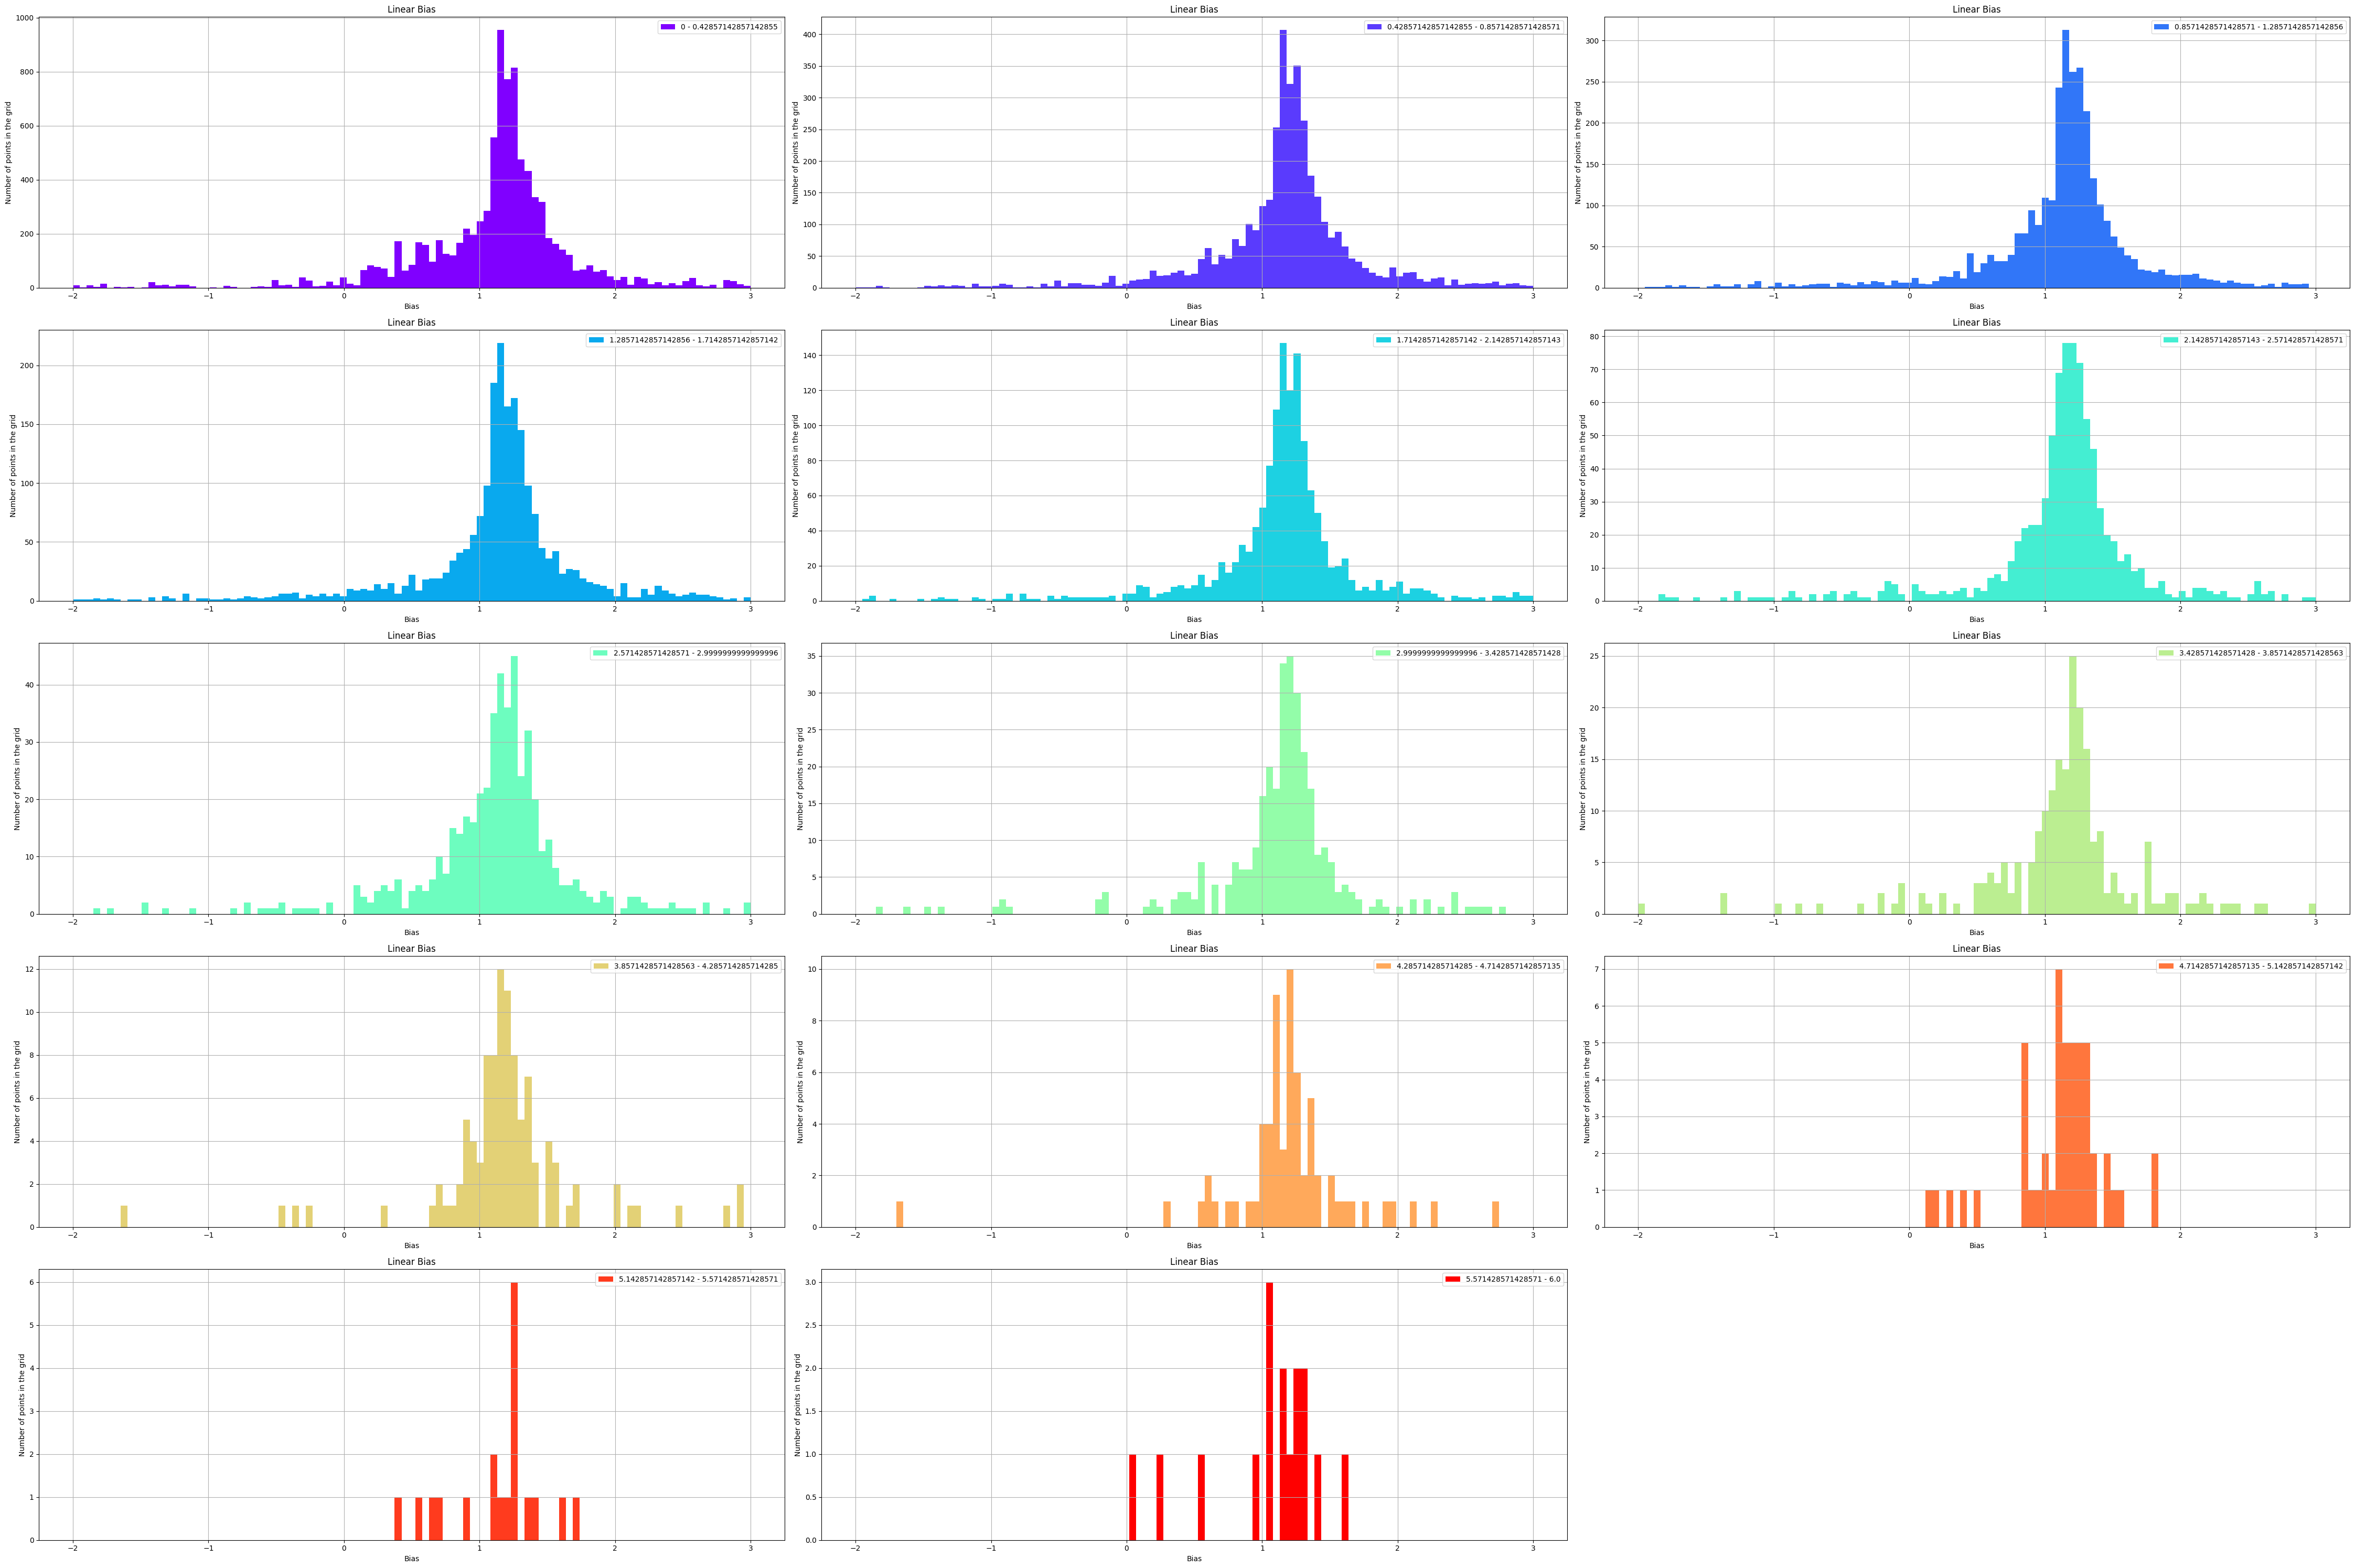

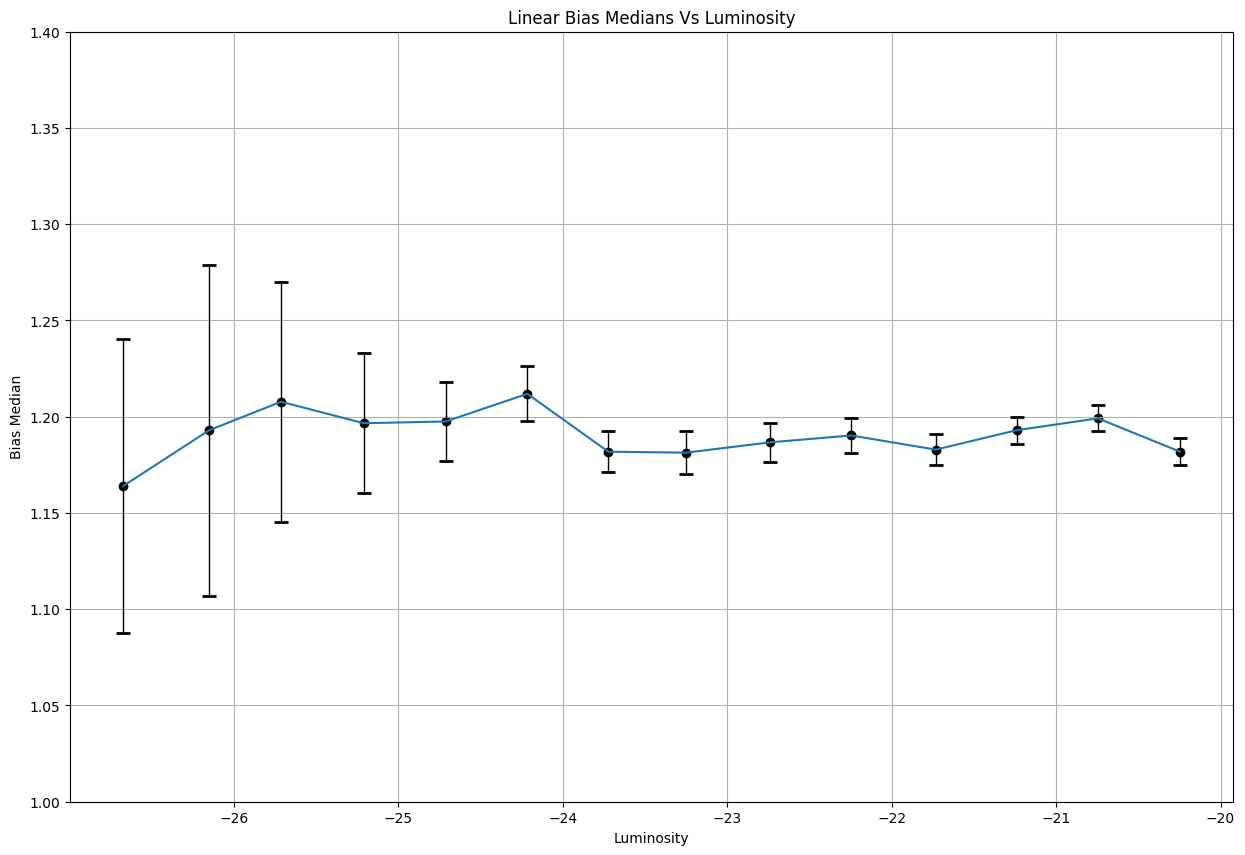

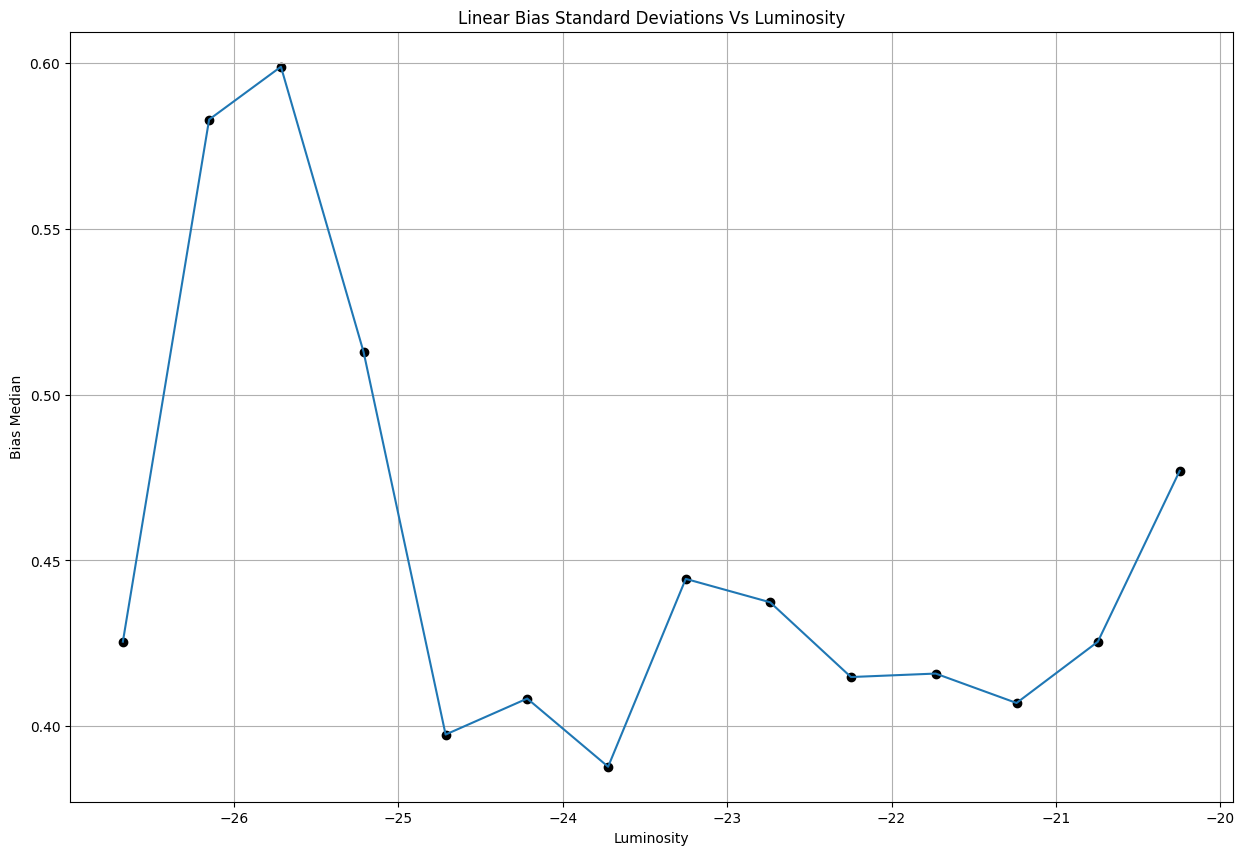

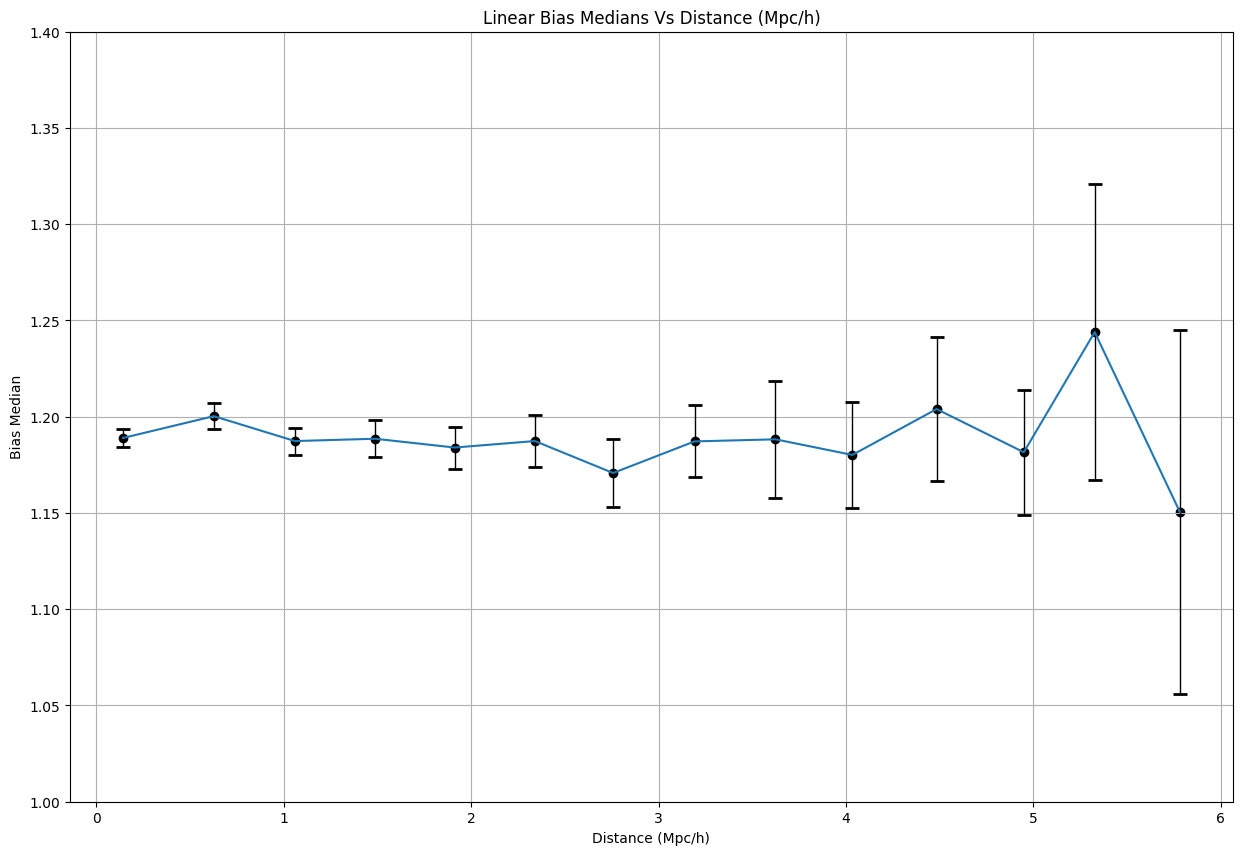

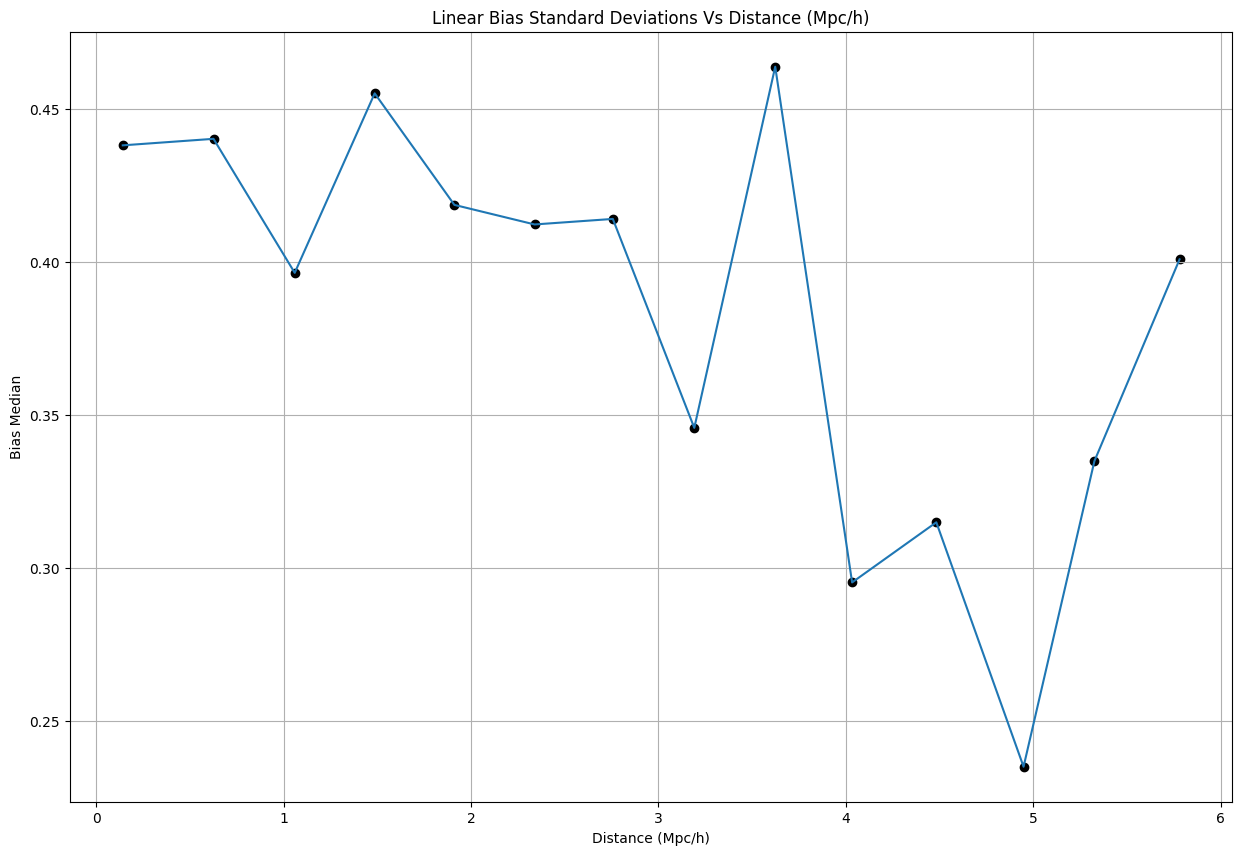

In [109]:
#TNG100

#Loading in Snapshot (density field)
TNG_delta=snapmaker(basePath1,99)

#Loading in Group (density field, luminosity, positions, and third closest neighbor distance)
TNG_delta_g, TNG_mag, TNG_pos=groupmaker(basePath2,99,k_max,k_min)
TNG_env=envmaker(TNG_pos)

#Unbinned Bias
TNG_b=(TNG_delta_g/TNG_delta).flatten()

#Making Luminosity Bins and Statistics
TNG_b_mag,TNG_mag_bin,mag_label=binmaker(k_max,k_min,bin_num,TNG_delta,TNG_delta_g,TNG_pos,TNG_mag)
TNG_mag_bin_med,TNG_b_mag_med,TNG_b_mag_err,TNG_b_mag_std=mdstdmaker(TNG_b_mag, TNG_mag_bin)

#Making Environment Bins
TNG_b_env, TNG_env_bin, env_label=binmaker(env_max,env_min,bin_num,TNG_delta,TNG_delta_g,TNG_pos,TNG_env)
TNG_env_bin_med,TNG_b_env_med,TNG_b_env_err,TNG_b_env_std=mdstdmaker(TNG_b_env, TNG_env_bin)

#Plots (Boolean to Left of Sim name determines if figure will be saved)
biashist(TNG_b,None,True,False,TNG)
biashist(TNG_b_mag,mag_label,False,False,TNG)
biashist(TNG_b_env,env_label,False,False,TNG)

medscat(TNG_mag_bin_med,TNG_b_mag_med, TNG_b_mag_err,'Luminosity',False,TNG,False)
stdscat(TNG_mag_bin_med,TNG_b_mag_std,'Luminosity',False,TNG)

medscat(TNG_env_bin_med,TNG_b_env_med, TNG_b_env_err,'Distance (Mpc/h)',False,TNG,False)
stdscat(TNG_env_bin_med,TNG_b_env_std,'Distance (Mpc/h)',False,TNG)


/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:1030: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


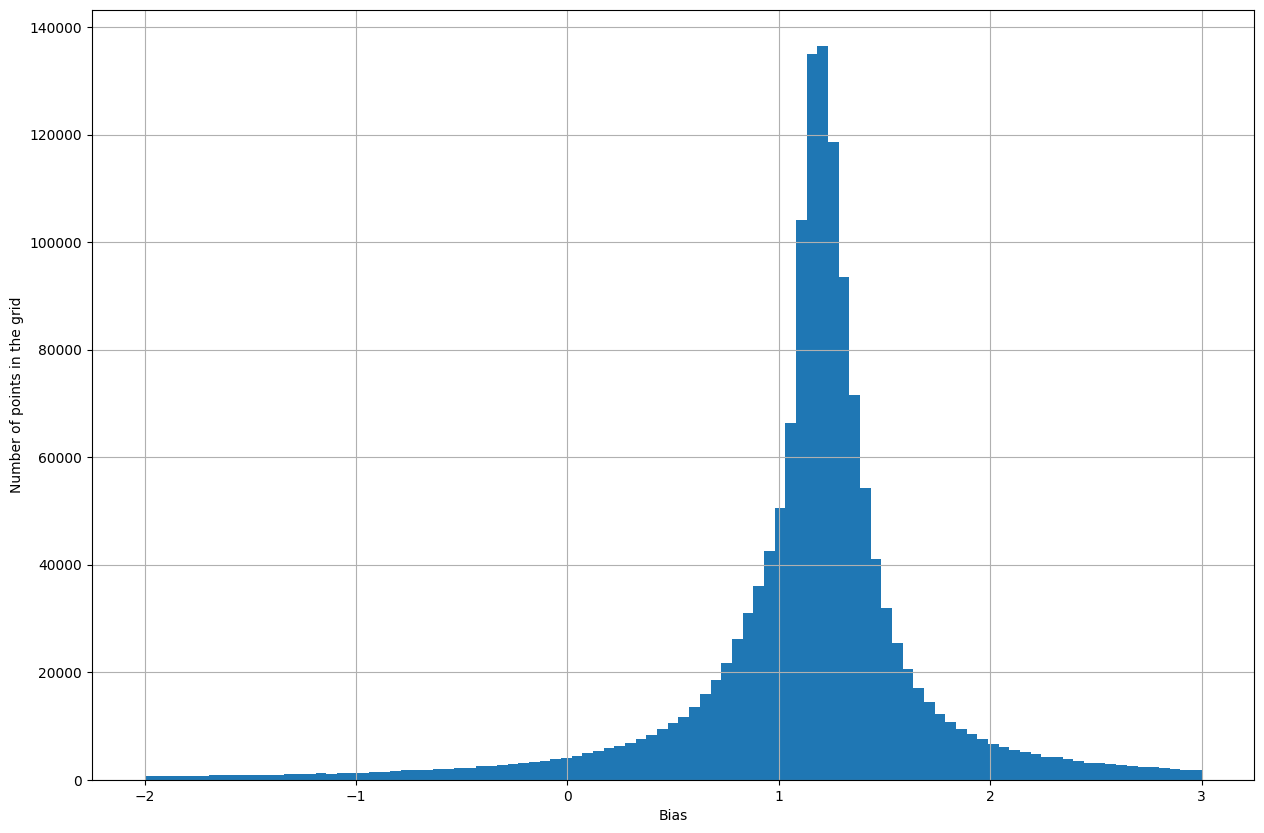

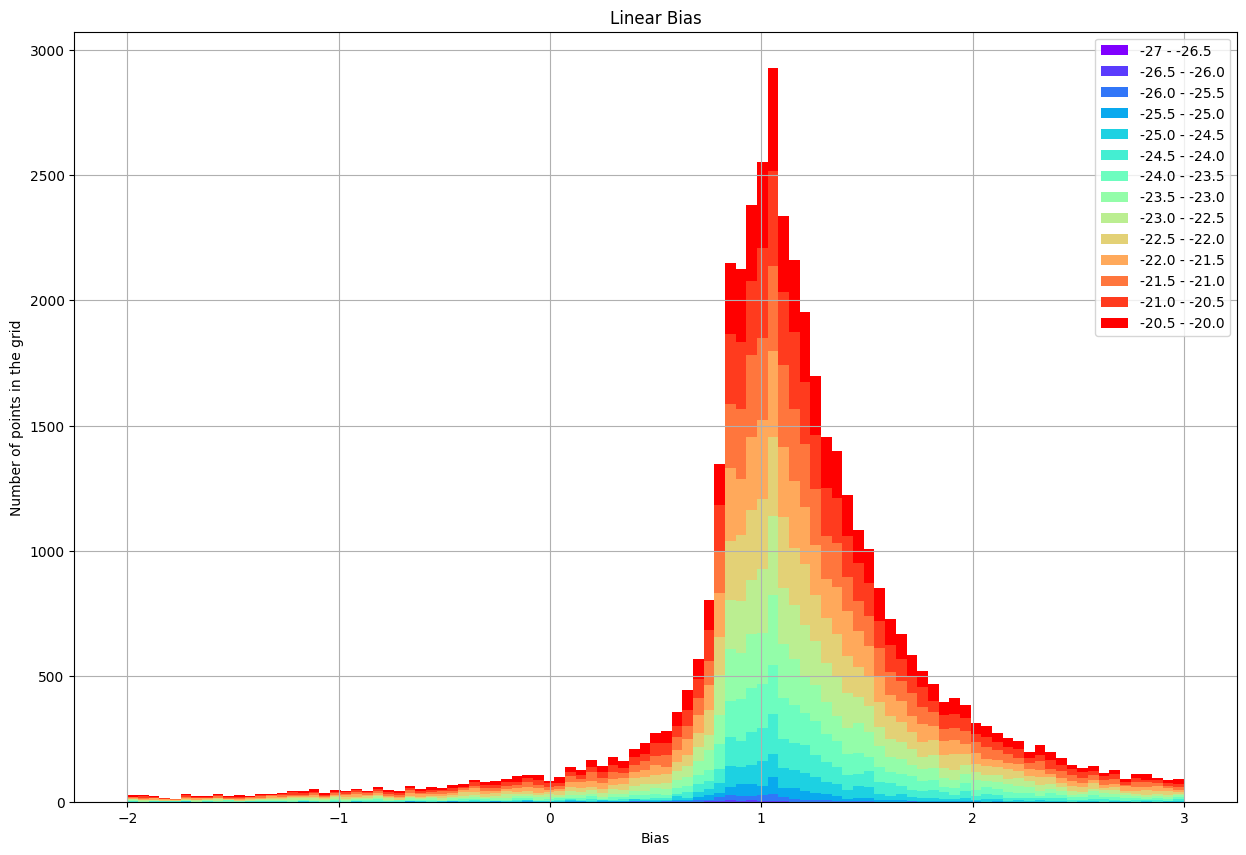

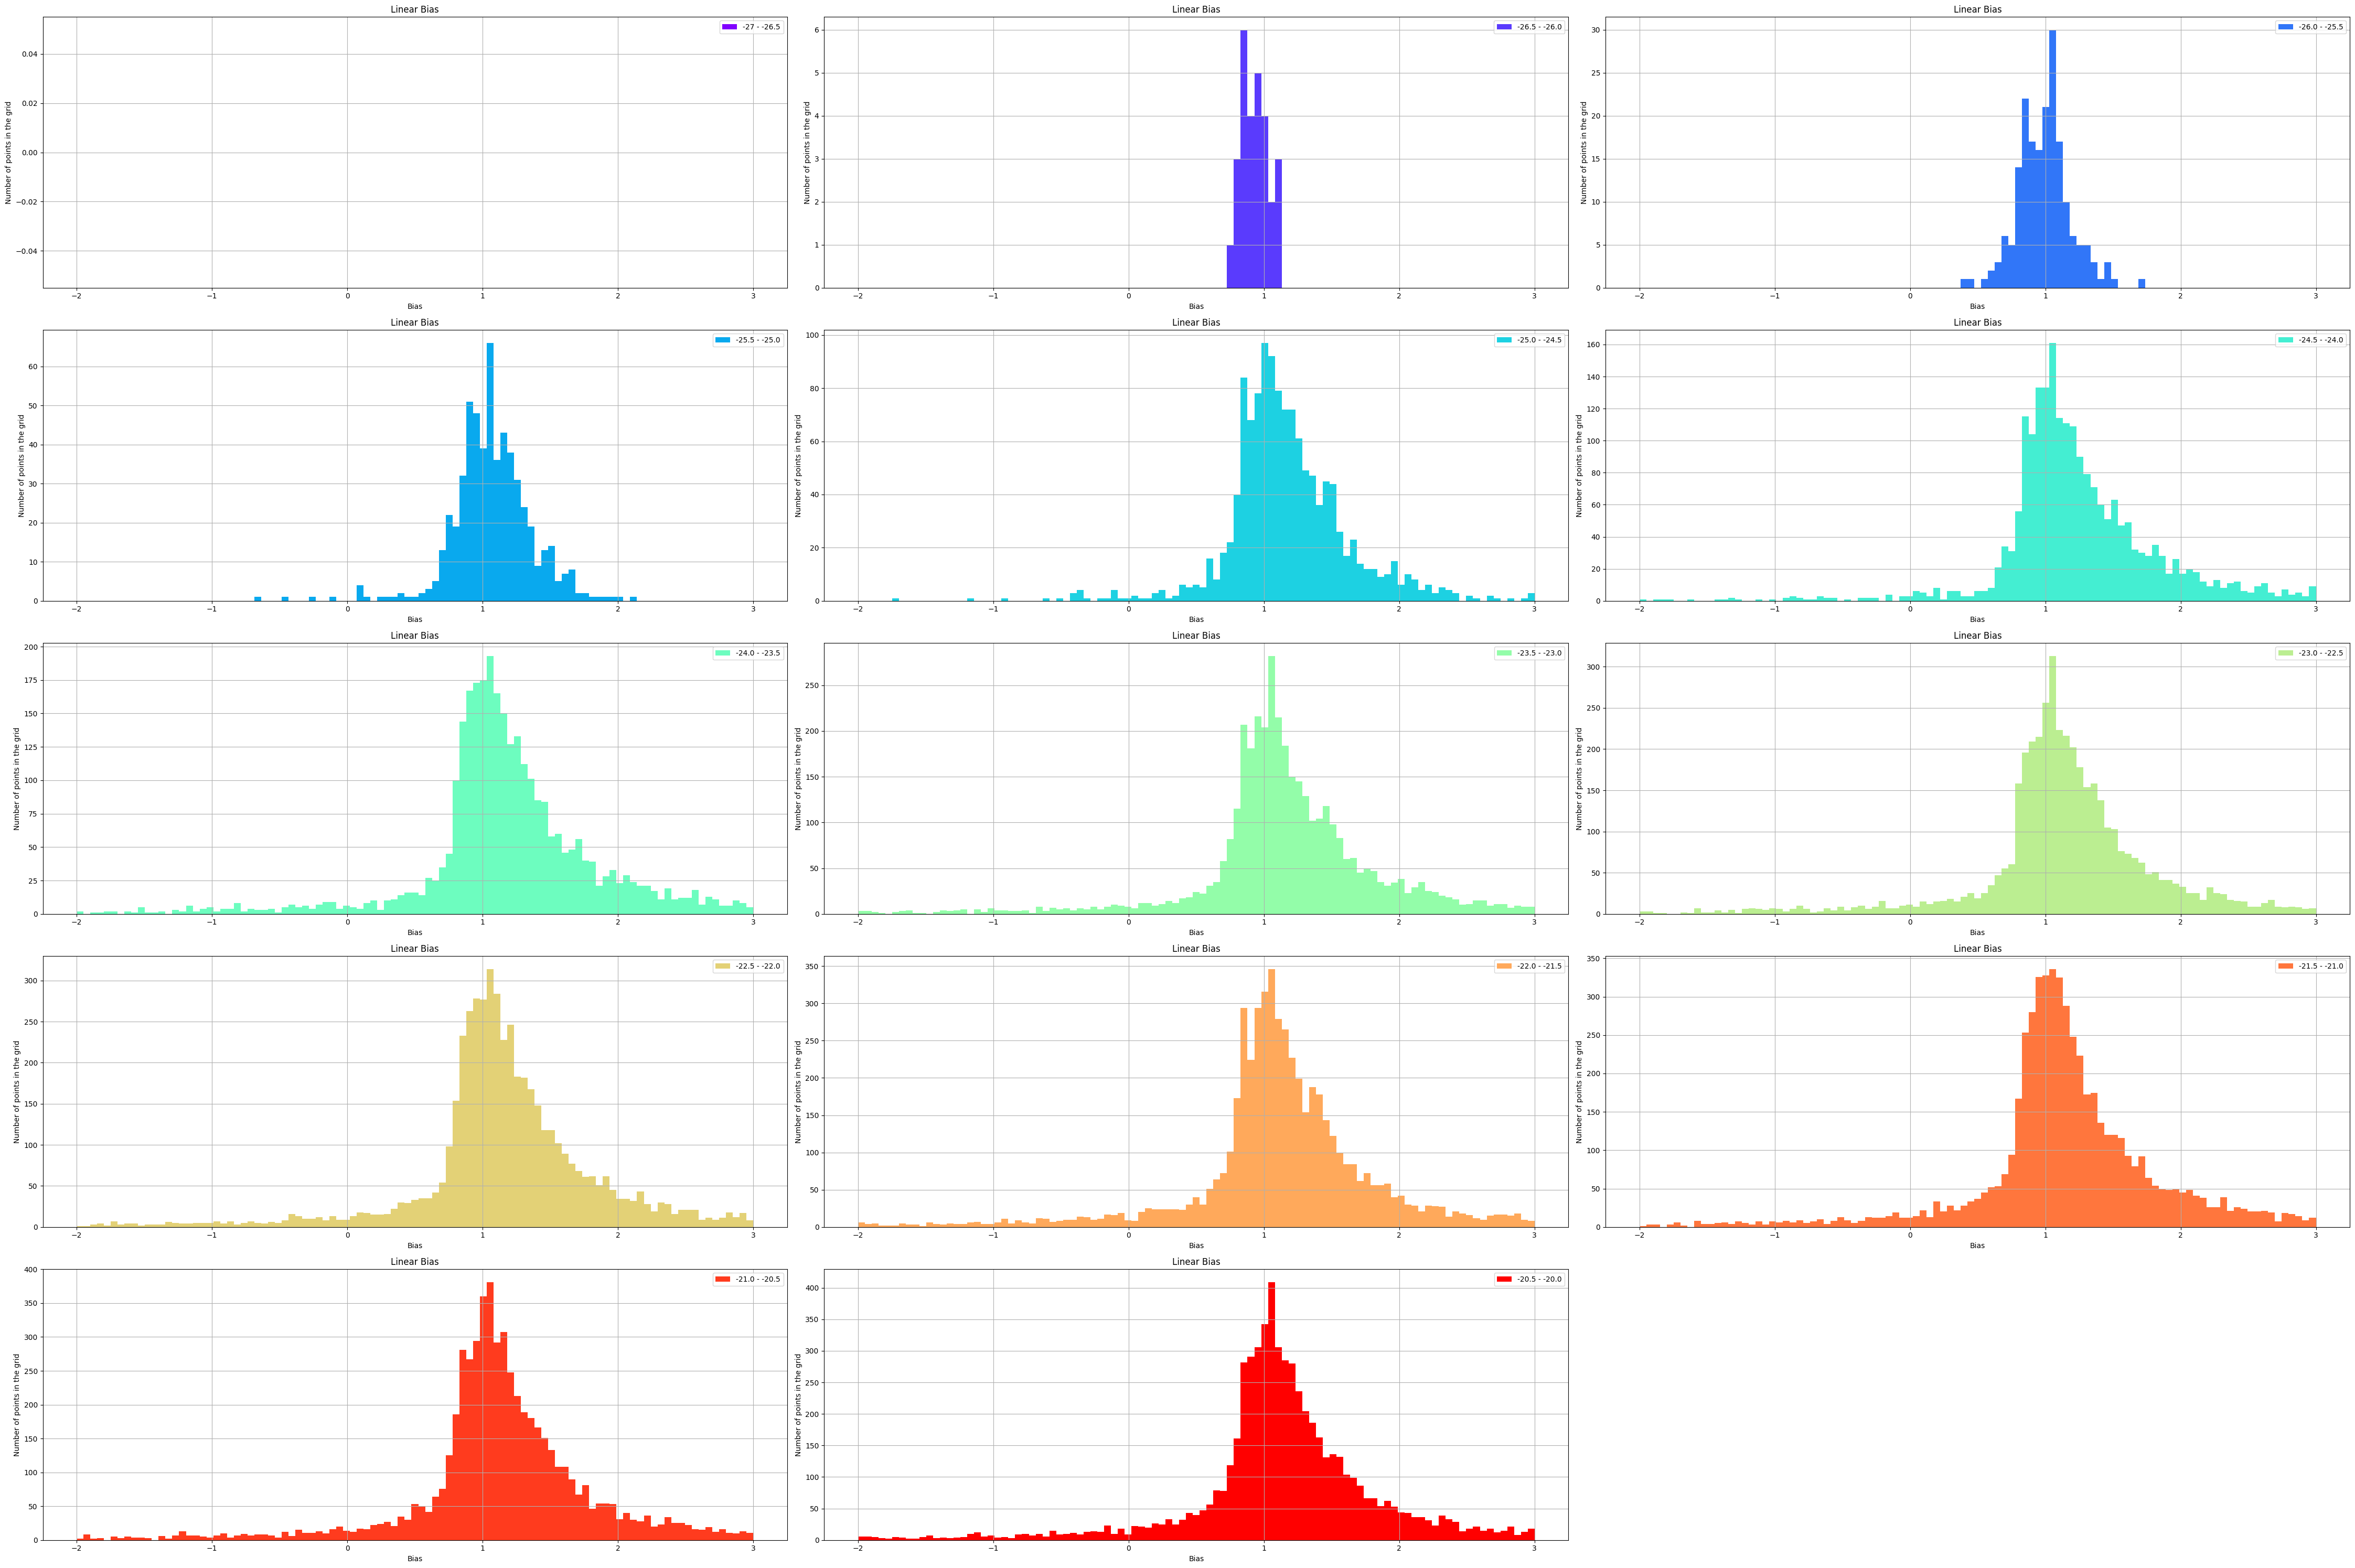

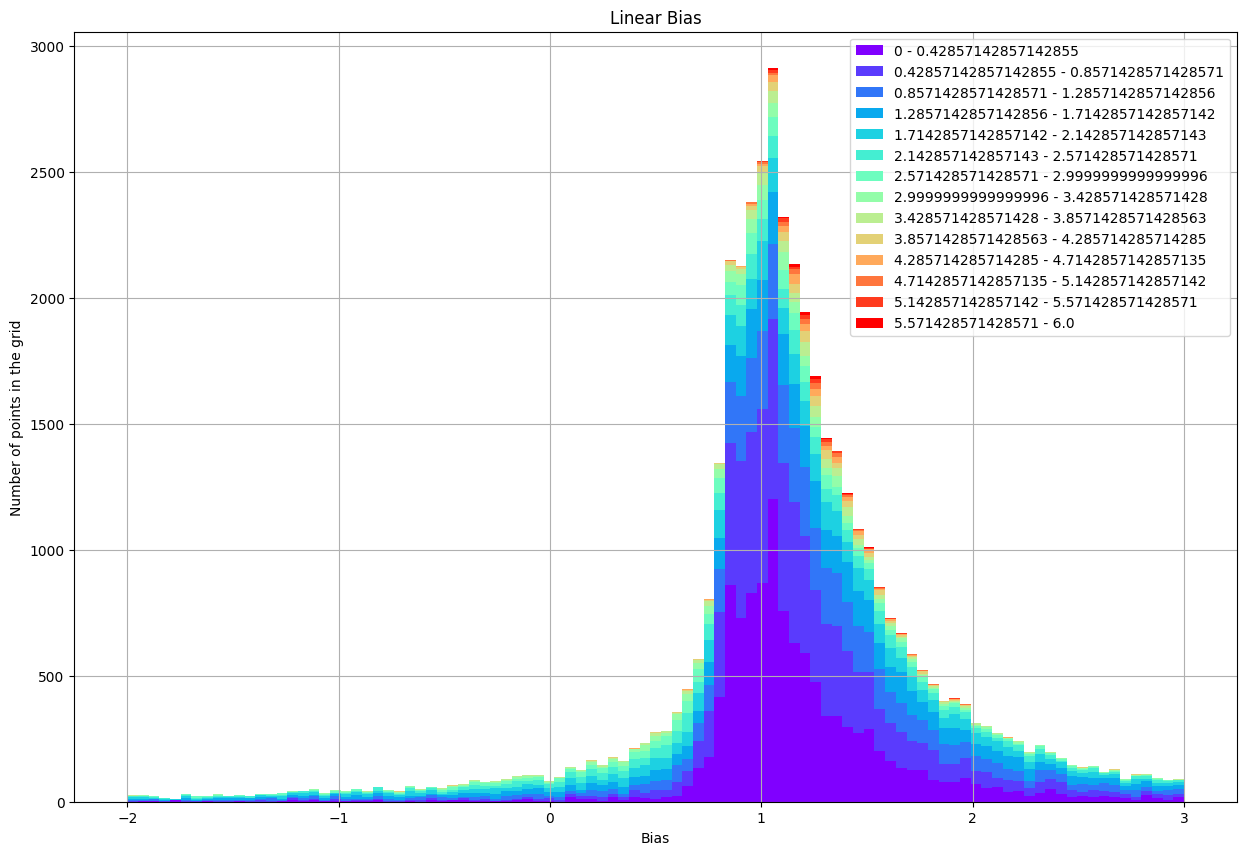

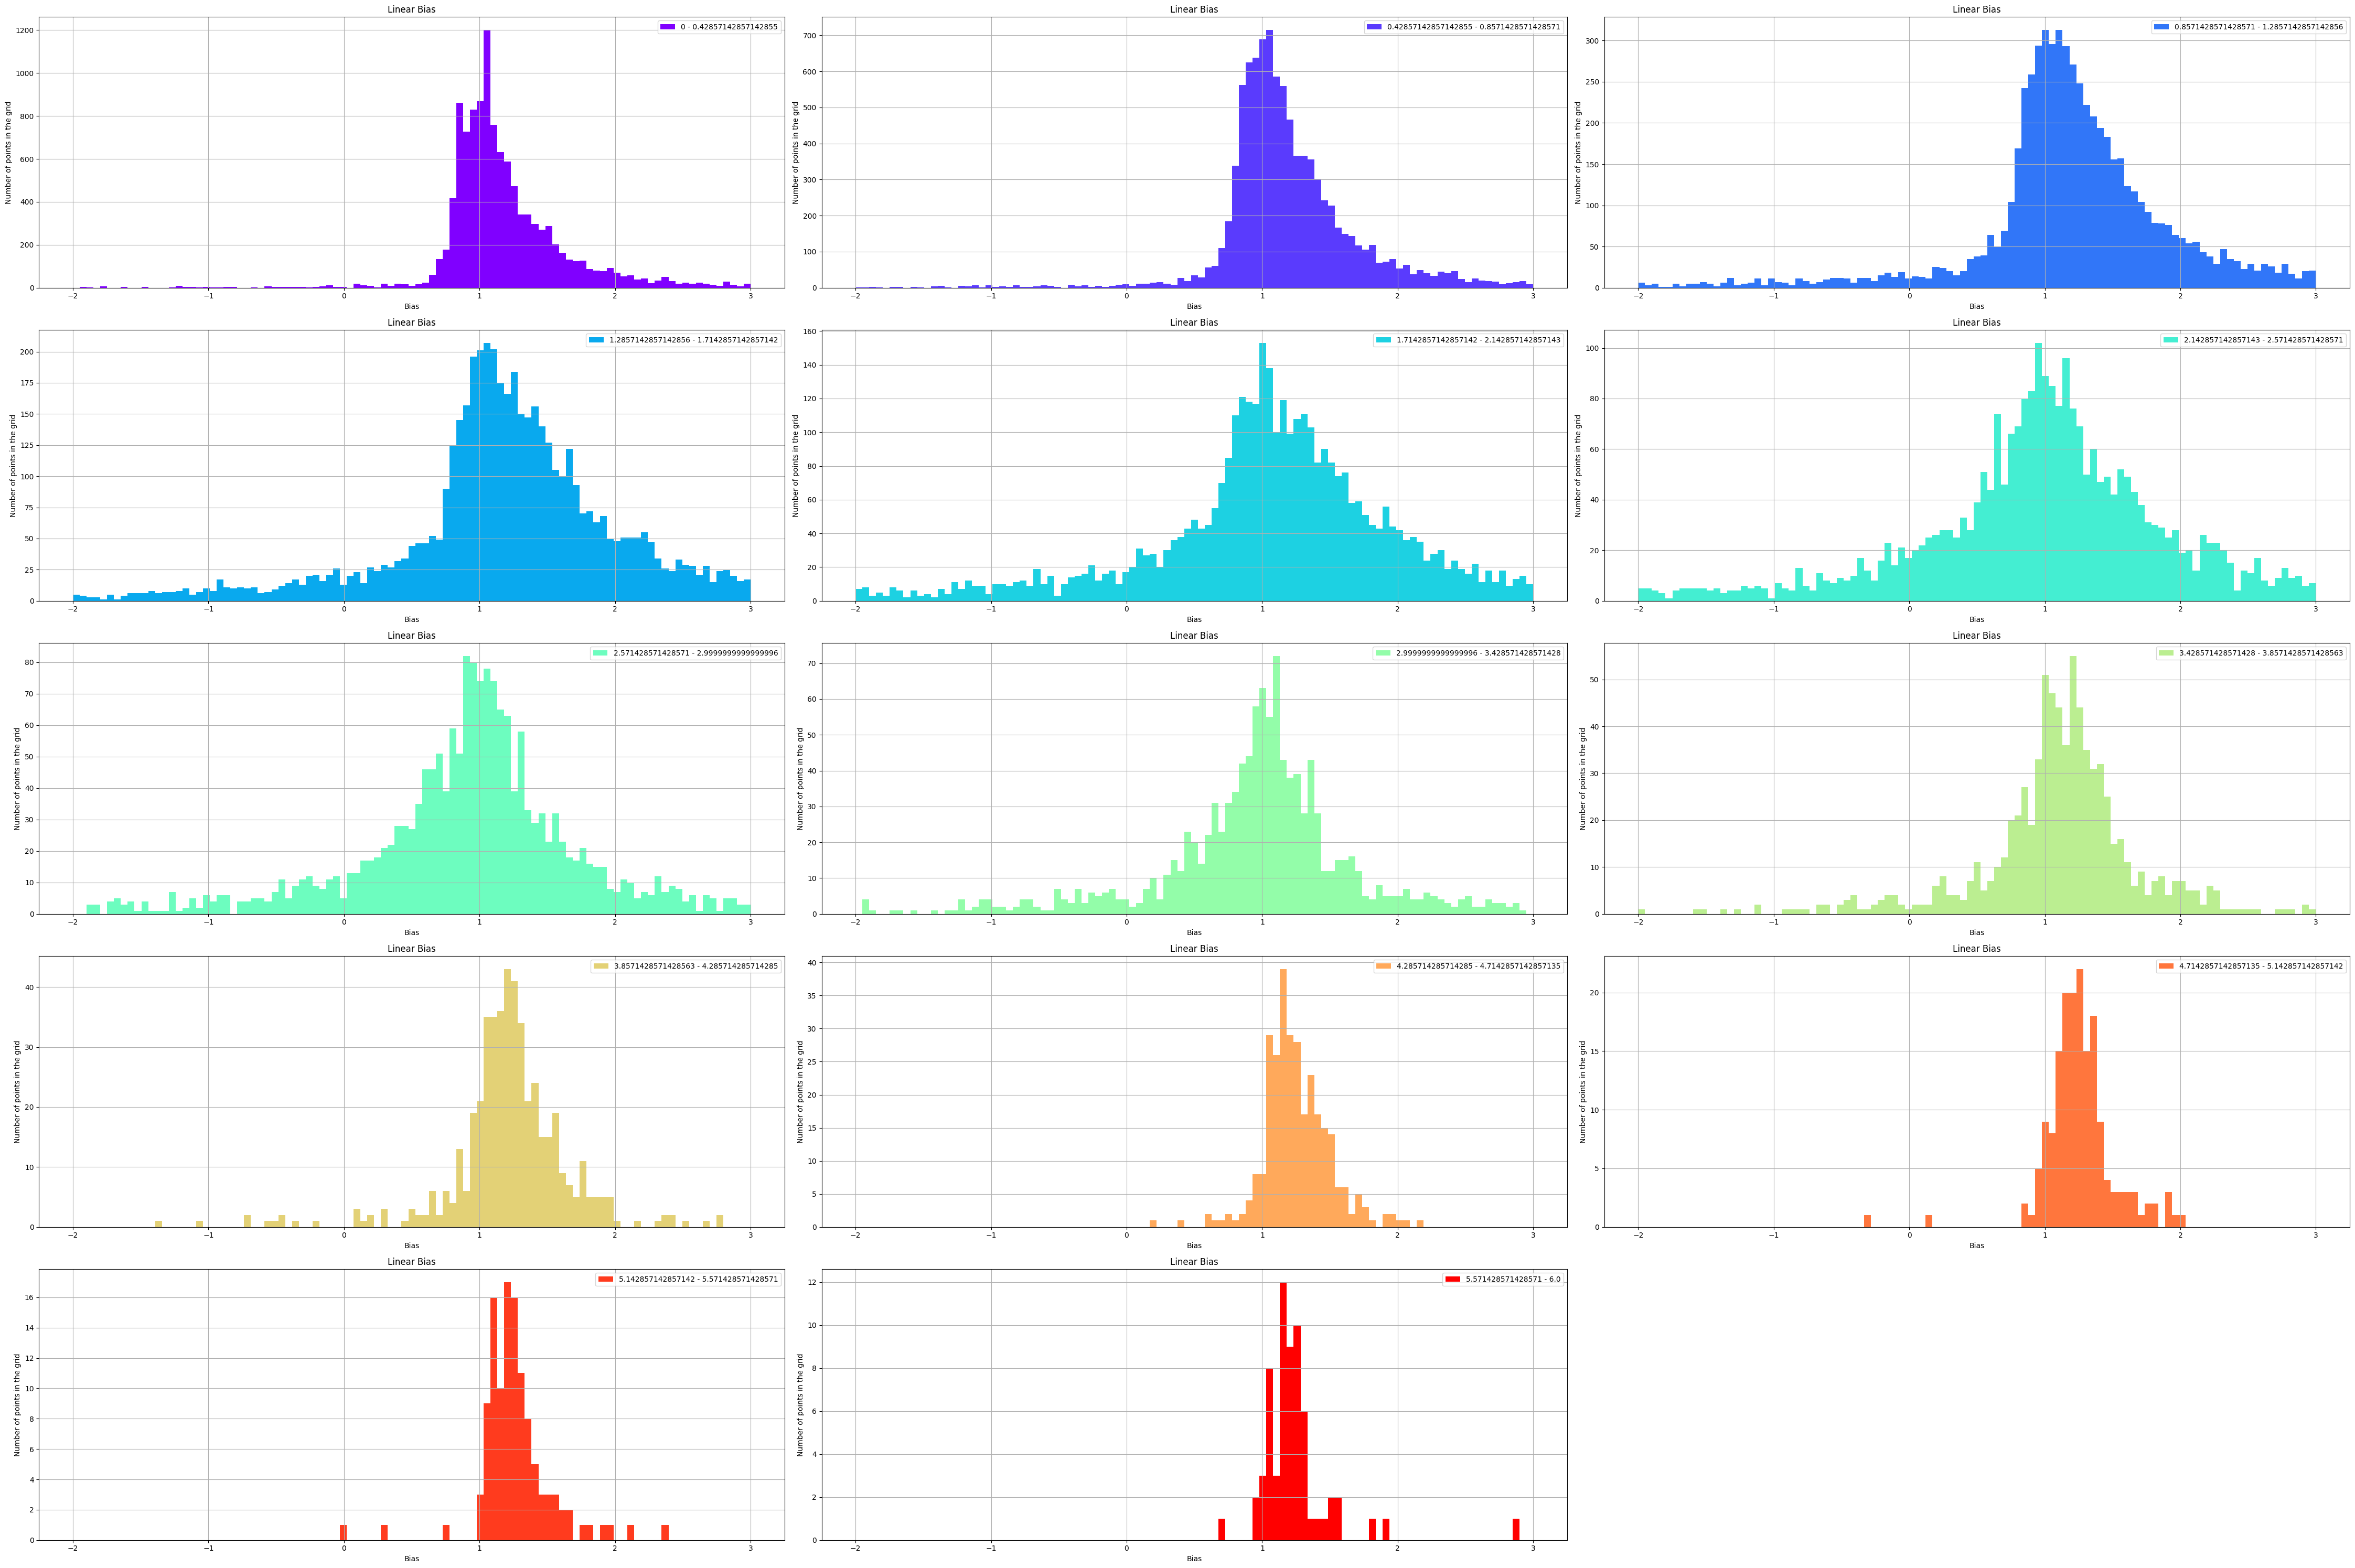

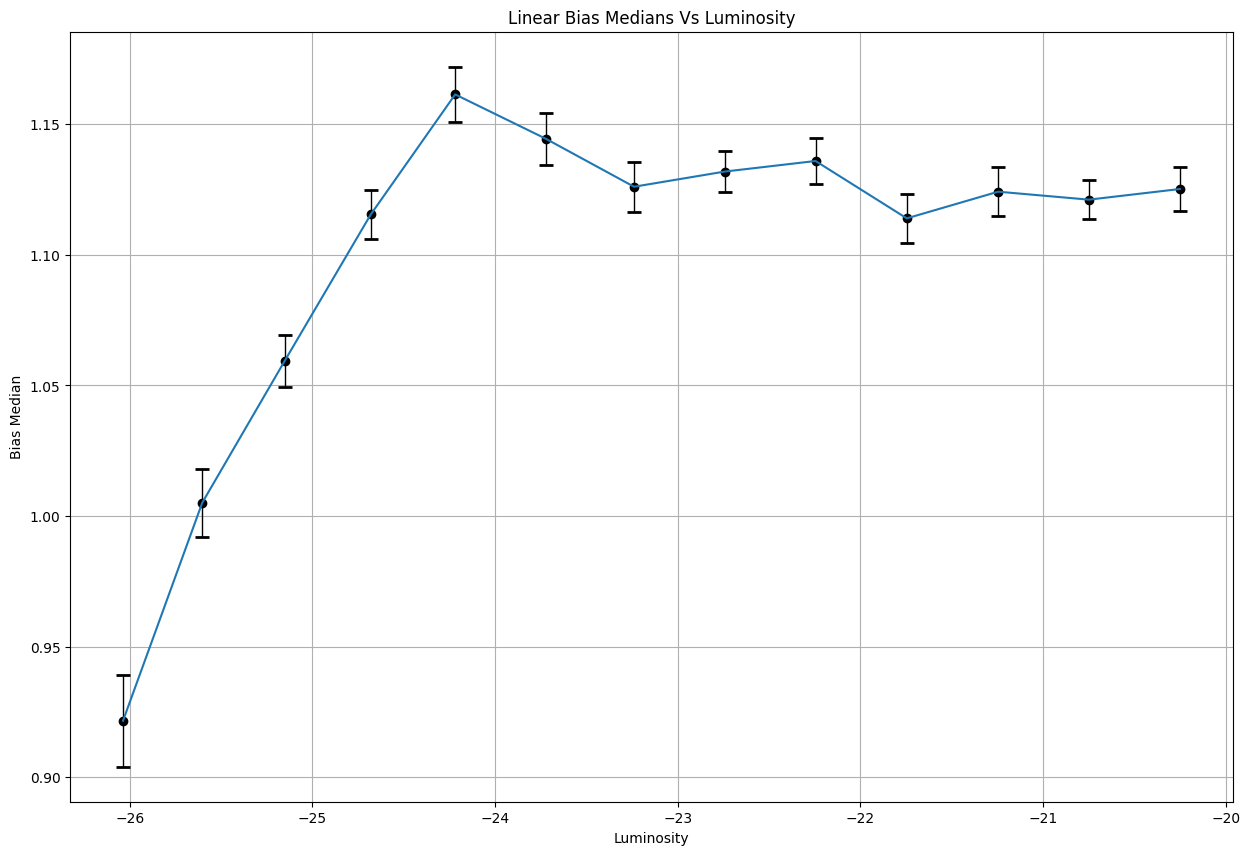

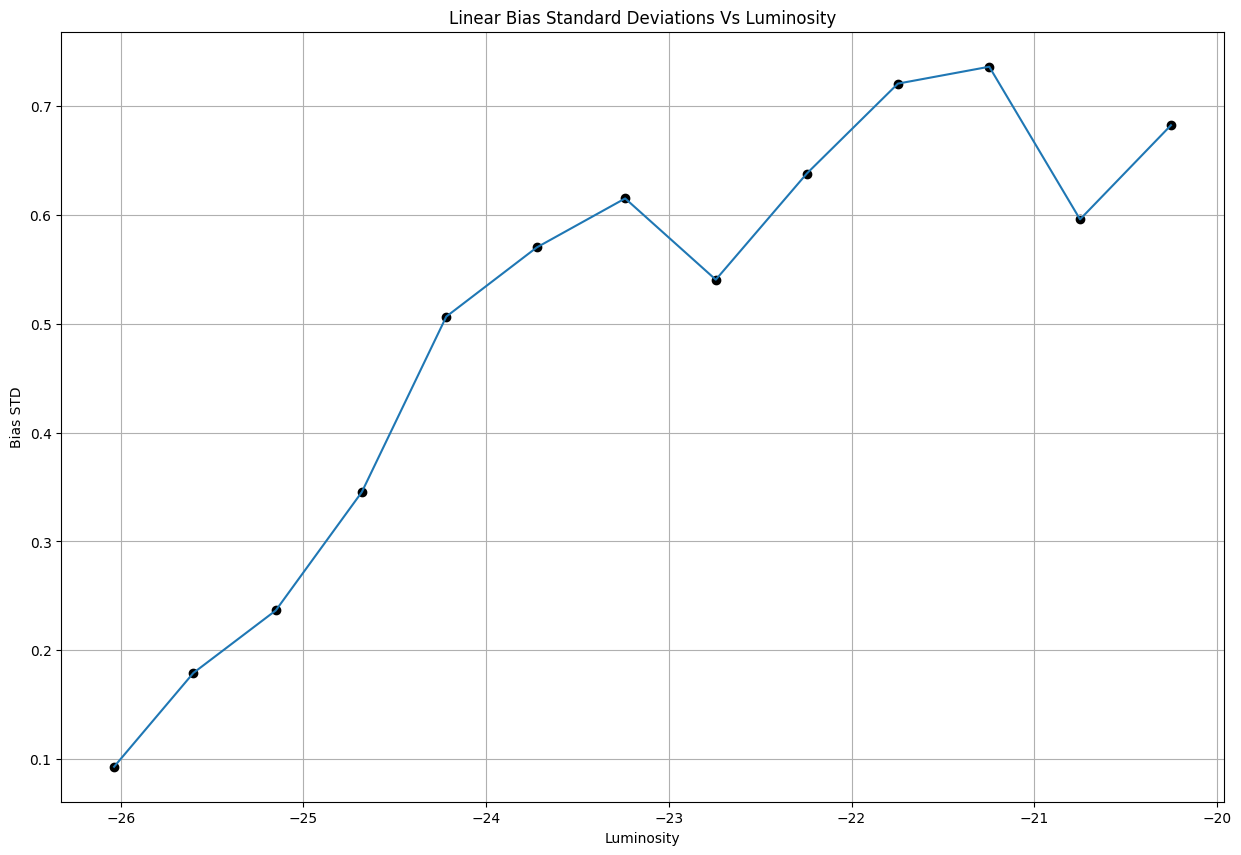

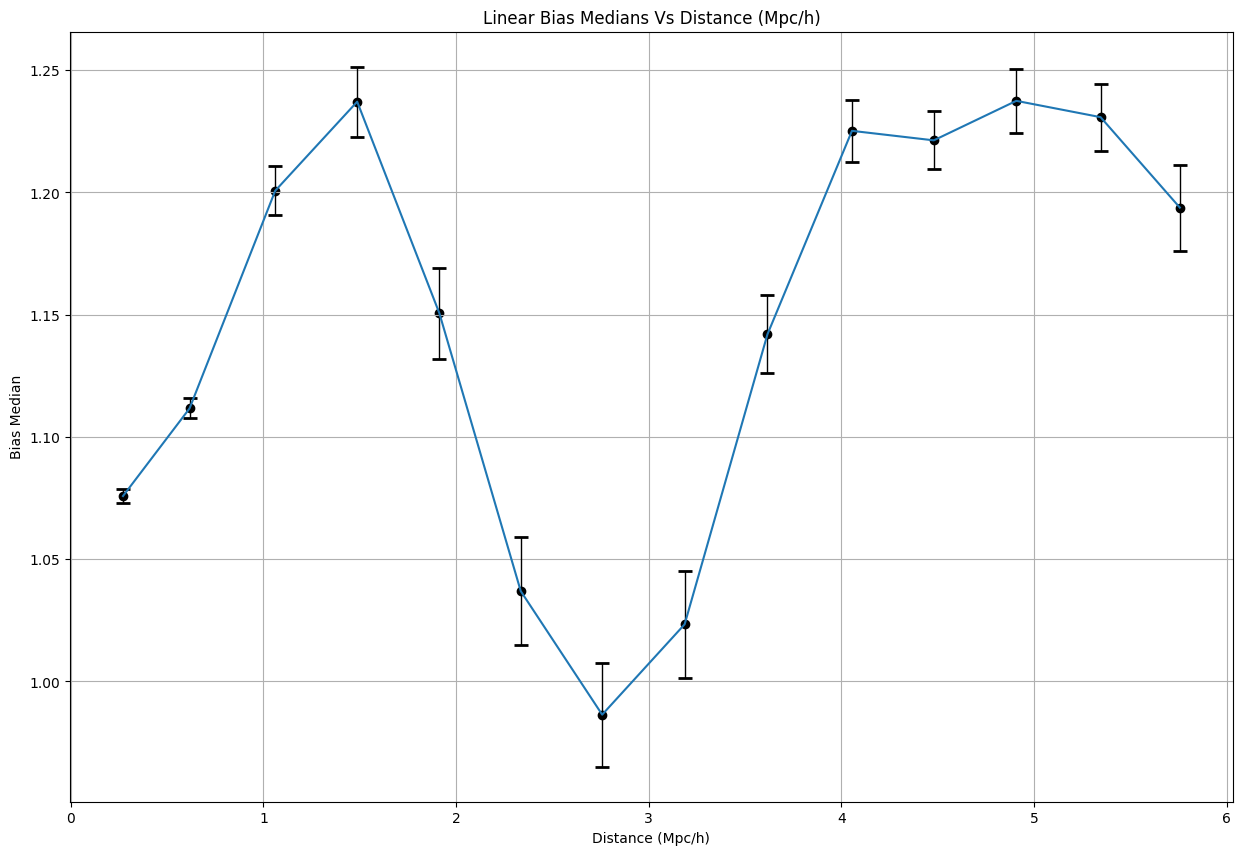

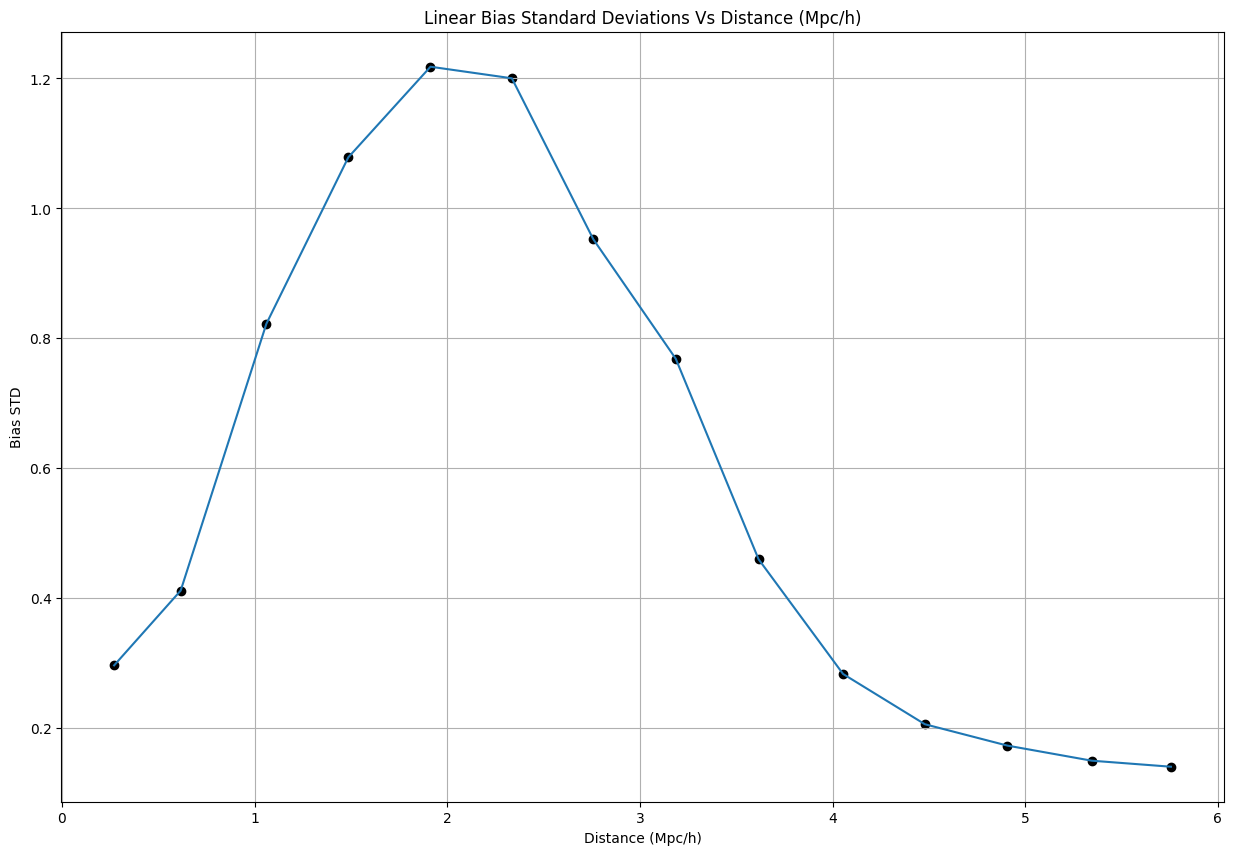

In [156]:
#OG
#Loading in Group and snapshot (density field, luminosity, positions, and third closest neighbor distance)
OG_delta, OG_delta_g, OG_mag, OG_pos=OGmaker(OGgroupPathOGsnapPath,k_max,k_min)
OG_env=envmaker(OG_pos)

#Unbinned Bias
OG_b=(OG_delta_g/OG_delta).flatten()

#Making Luminosity Bins and Statistics
OG_b_mag,OG_mag_bin,mag_label=binmaker(k_max,k_min,bin_num,OG_delta,OG_delta_g,OG_pos,OG_mag)
OG_mag_bin_med,OG_b_mag_med,OG_b_mag_err,OG_b_mag_std=mdstdmaker(OG_b_mag, OG_mag_bin)

#Making Environment Bins
OG_b_env, OG_env_bin, env_label=binmaker(env_max,env_min,bin_num,OG_delta,OG_delta_g,OG_pos,OG_env)
OG_env_bin_med,OG_b_env_med,OG_b_env_err,OG_b_env_std=mdstdmaker(OG_b_env, OG_env_bin)

#Plots (Boolean to Left of Sim name determines if figure will be saved)
biashist(OG_b,None,True,False,OG)
biashist(OG_b_mag,mag_label,False,False,OG)
biashist(OG_b_env,env_label,False,False,OG)

medscat(OG_mag_bin_med,OG_b_mag_med, OG_b_mag_err,'Luminosity',False,OG,False)
stdscat(OG_mag_bin_med,OG_b_mag_std,'Luminosity',False,OG,False)

medscat(OG_env_bin_med,OG_b_env_med, OG_b_env_err,'Distance (Mpc/h)',False,OG,False)
stdscat(OG_env_bin_med,OG_b_env_std,'Distance (Mpc/h)',False,OG,False)

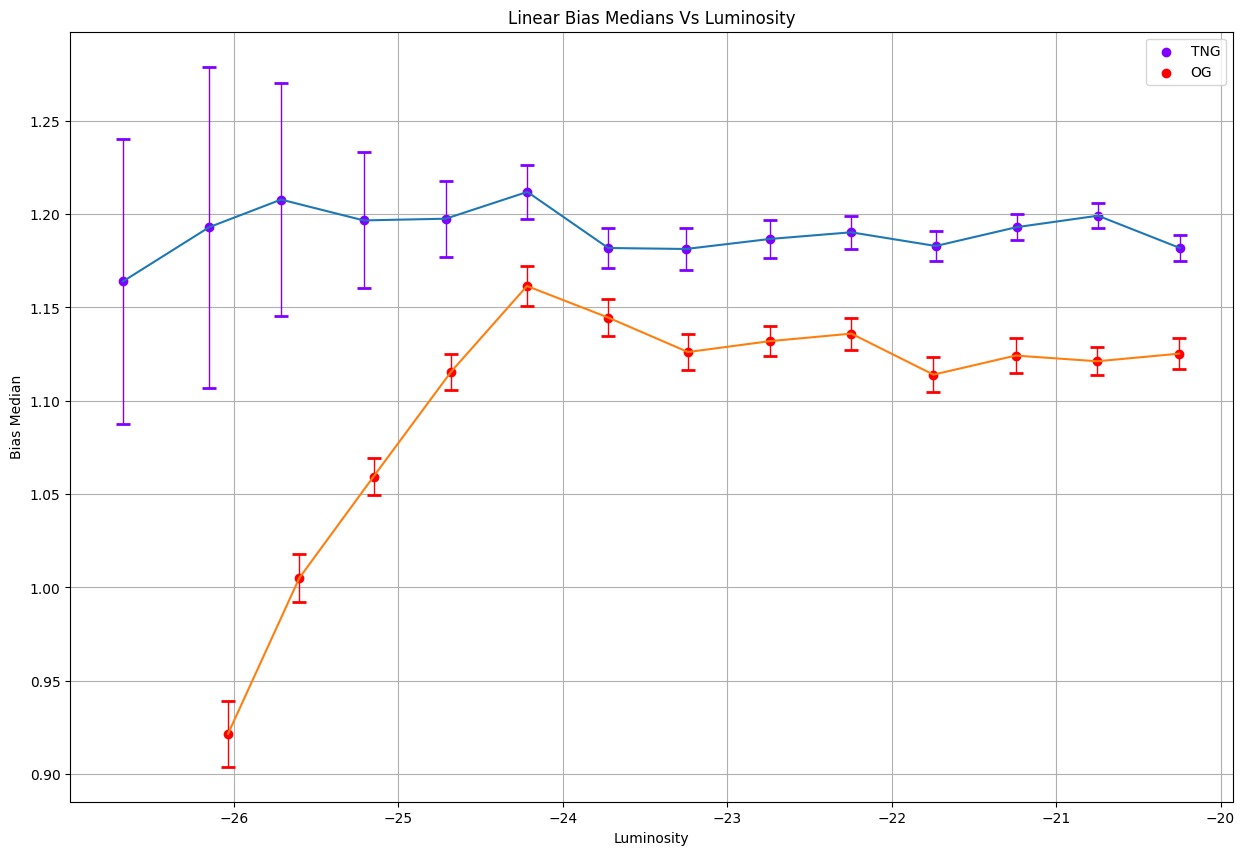

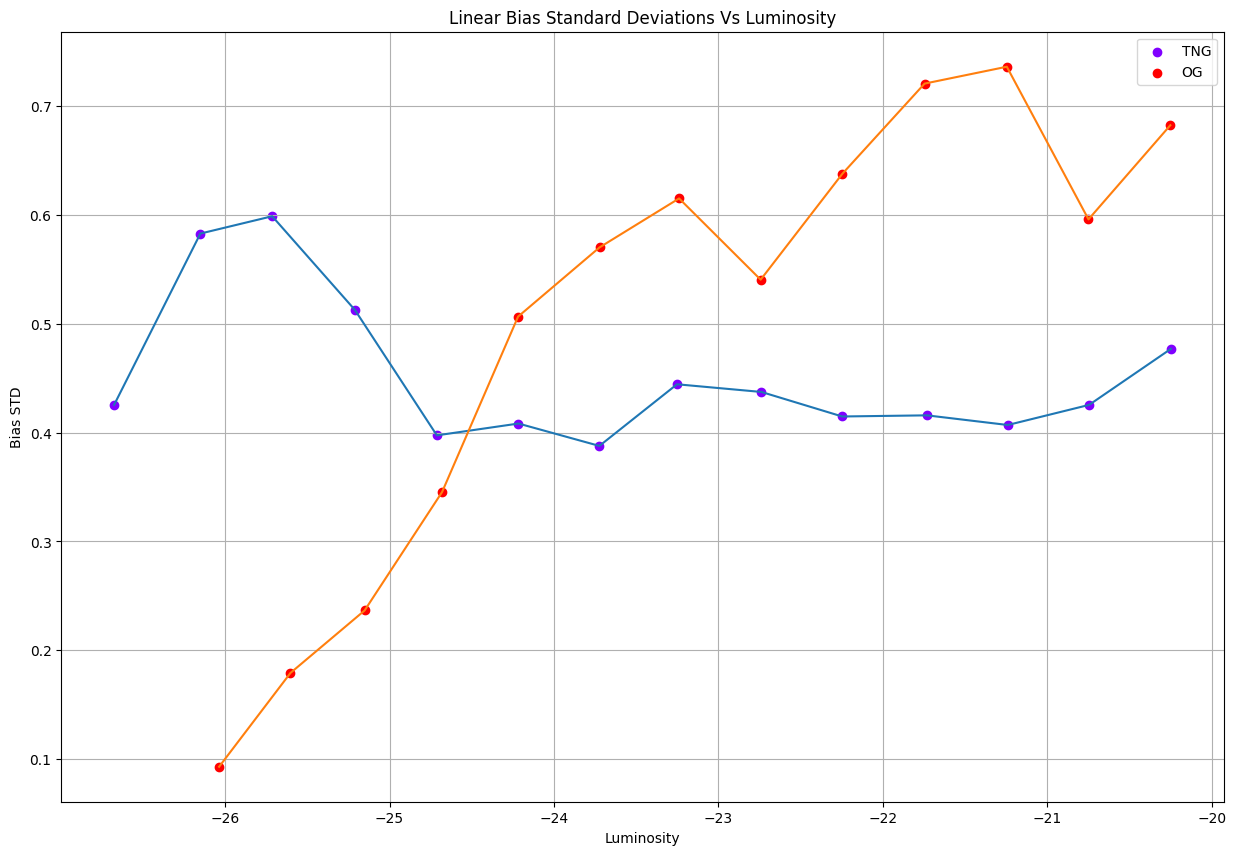

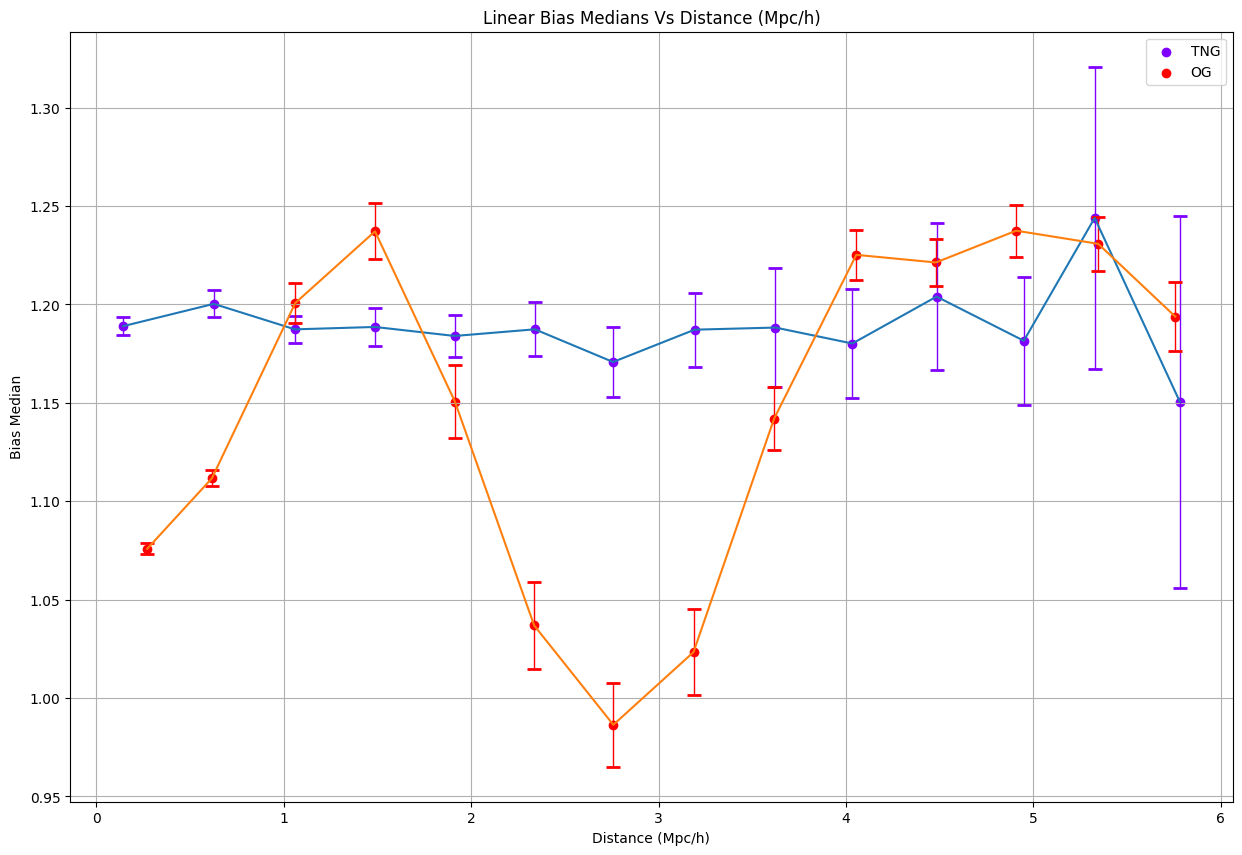

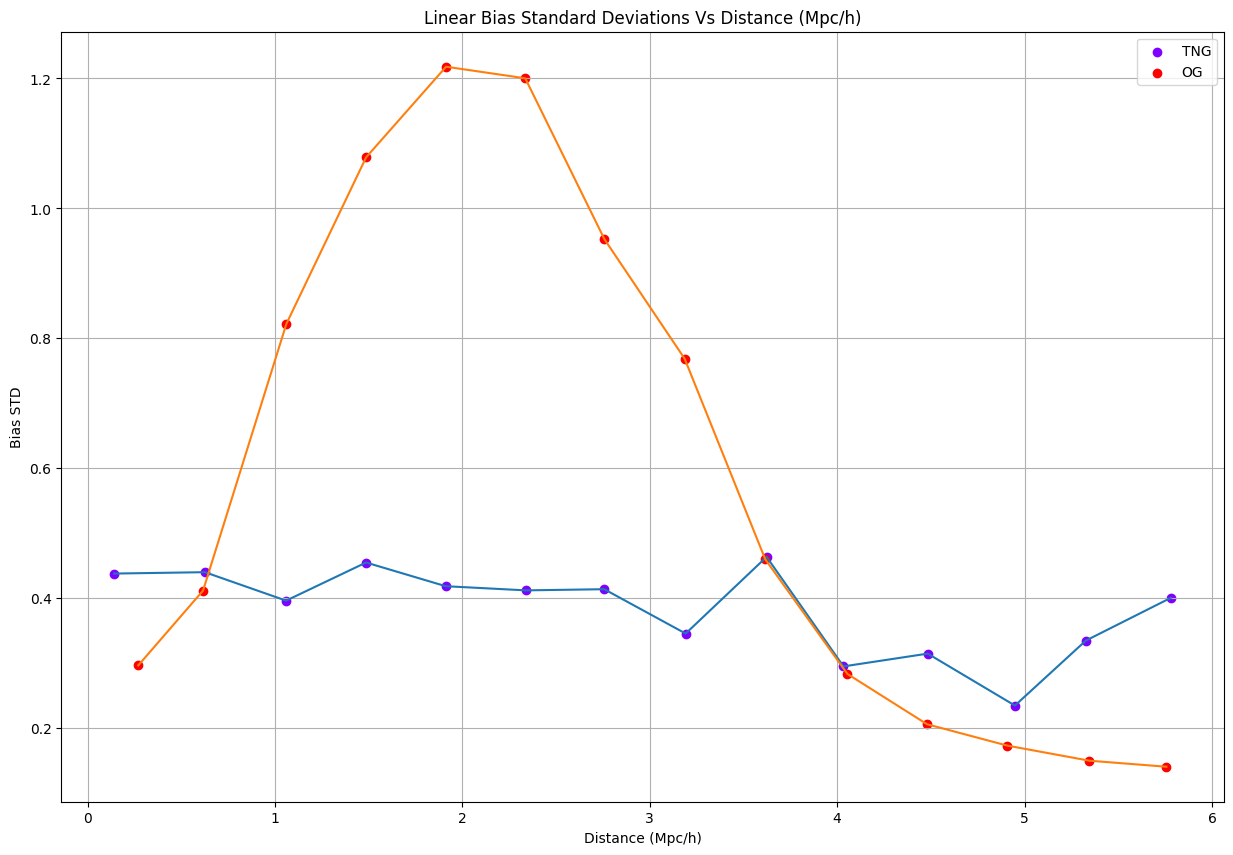

In [175]:
# Comparison between TNG and OG 
comp_mag_bin_med=[TNG_mag_bin_med, OG_mag_bin_med]
comp_b_mag_med=[TNG_b_mag_med,OG_b_mag_med]
comp_b_mag_err=[TNG_b_mag_err,OG_b_mag_err]
comp_b_mag_std=[TNG_b_mag_std,OG_b_mag_std]

comp_env_bin_med=[TNG_env_bin_med, OG_env_bin_med]
comp_b_env_med=[TNG_b_env_med,OG_b_env_med]
comp_b_env_err=[TNG_b_env_err,OG_b_env_err]
comp_b_env_std=[TNG_b_env_std,OG_b_env_std]

comp=[TNG,OG]

#
medscat(comp_mag_bin_med,comp_b_mag_med, comp_b_mag_err,'Luminosity',False,comp,True)
stdscat(comp_mag_bin_med,comp_b_mag_std,'Luminosity',False,comp,True)

medscat(comp_env_bin_med,comp_b_env_med, comp_b_env_err,'Distance (Mpc/h)',False,comp,True)
stdscat(comp_env_bin_med,comp_b_env_std,'Distance (Mpc/h)',False,comp,True)